In [ ]:
# KNN Decision Analysis for State Change Signals
print("=== KNN Decision Analysis for State Change Signals ===\n")

# Use the same monthly data structure as the signal generation
for month_name, month_data in monthly_data.items():
    print(f"\n--- Analysis for {month_name} ---")
    
    # Get the state change signals for this month (replicating Cell 18 logic)
    month_predictions = generate_predictions(knn_model, month_data, feature_columns, model_type=model_type)
    
    # Apply the same filtering logic as Cell 18 to get state change signals
    month_signals = []
    current_state = 'HOLD'
    
    for i, row in month_predictions.iterrows():
        predicted_label = row['predicted_label']
        confidence = row['confidence']
        
        if confidence >= 0.70:  # Same threshold as Cell 18
            if predicted_label == 1 and current_state != 'BUY':
                month_signals.append({
                    'timestamp': row['timestamp'],
                    'signal': 'BUY',
                    'confidence': confidence,
                    'close_price': row['close_price'],
                    'index': i
                })
                current_state = 'BUY'
            elif predicted_label == 0 and current_state != 'SELL':
                month_signals.append({
                    'timestamp': row['timestamp'],
                    'signal': 'SELL', 
                    'confidence': confidence,
                    'close_price': row['close_price'],
                    'index': i
                })
                current_state = 'SELL'
    
    if not month_signals:
        print(f"No state change signals found for {month_name}")
        continue
        
    print(f"Found {len(month_signals)} state change signals")
    
    # Analyze first few signals in detail
    signals_to_analyze = min(3, len(month_signals))
    print(f"\nDetailed analysis of first {signals_to_analyze} signals:")
    
    for i, signal in enumerate(month_signals[:signals_to_analyze]):
        print(f"\nSignal {i+1}: {signal['signal']} at {signal['timestamp']}")
        print(f"  Confidence: {signal['confidence']:.3f}")
        print(f"  Price: ${signal['close_price']:.2f}")
        
        # Get the prediction row for this signal
        signal_idx = signal['index']
        signal_row = month_predictions.iloc[signal_idx]
        
        # Create a local KNN for neighbor analysis using the month's data
        from sklearn.neighbors import NearestNeighbors
        
        # Prepare feature data for this month
        X_month = month_predictions[feature_columns].values
        
        # Fit local KNN with same parameters as original model
        local_knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
        local_knn.fit(X_month)
        
        # Find neighbors for this signal point
        signal_features = signal_row[feature_columns].values.reshape(1, -1)
        distances, neighbor_indices = local_knn.kneighbors(signal_features)
        
        print(f"  Nearest neighbors analysis:")
        for j, (dist, idx) in enumerate(zip(distances[0], neighbor_indices[0])):
            neighbor_row = month_predictions.iloc[idx]
            neighbor_pred = knn_model.predict(neighbor_row[feature_columns].values.reshape(1, -1))[0]
            neighbor_conf = knn_model.predict_proba(neighbor_row[feature_columns].values.reshape(1, -1))[0].max()
            
            print(f"    Neighbor {j+1}: Distance={dist:.3f}, Prediction={neighbor_pred}, Confidence={neighbor_conf:.3f}")
        
        # Show key feature values
        print(f"  Key features:")
        key_features = ['rsi_14', 'macd_signal', 'bb_percent', 'ema_20', 'sma_50']
        available_features = [f for f in key_features if f in feature_columns]
        
        for feature in available_features[:5]:  # Show top 5 available features
            value = signal_row[feature]
            print(f"    {feature}: {value:.4f}")
    
    print(f"\nSummary for {month_name}:")
    buy_signals = sum(1 for s in month_signals if s['signal'] == 'BUY')
    sell_signals = sum(1 for s in month_signals if s['signal'] == 'SELL')
    avg_confidence = sum(s['confidence'] for s in month_signals) / len(month_signals)
    
    print(f"  BUY signals: {buy_signals}")
    print(f"  SELL signals: {sell_signals}")
    print(f"  Average confidence: {avg_confidence:.3f}")
    print("-" * 50)

# Monthly BTC Price Trend Prediction

This notebook uses monthly datasets and a trained KNeighborsClassifier model to predict future price trends and generate binary trading signals.

## Key Features:
- **Efficient Data Loading**: Uses pre-computed monthly datasets with technical indicators
- **No Recalculation**: Both CSV and ArcticDB datasets already contain technical indicators  
- **Pre-computed Targets**: Monthly datasets already have future_trend labels
- **Multiple Data Sources**: ArcticDB → CSV → Original dataset fallbacks
- **Robust Error Handling**: Graceful degradation when data sources unavailable

## Dataset Structure:
- **OHLCV Data**: Open, High, Low, Close, Volume
- **Technical Indicators**: 15 pre-computed indicators including EMA, SMA, MACD, RSI, Bollinger Bands, ATR, Fractal Dimension
- **Target Variables**: future_close, future_return, future_trend (binary)

## Approach:
1. Load monthly datasets from ArcticDB/CSV (with existing features)
2. Load pre-trained KNeighborsClassifier model  
3. Split data into validation/prediction sets
4. Generate predictions and binary signals
5. Evaluate prediction accuracy and trading performance
6. Export results for further analysis

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
import sys
from pathlib import Path
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

# Add project root to path for imports
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
sys.path.append(str(project_root / 'features'))

# Import configuration for adaptive paths
from config import config, ARCTIC_URI

# Import pipeline classes
from trend_indicator_pipeline_pkg import (
    TrendIndicatorPipeline, 
    MomentumIndicatorPipeline, 
    VolatilityIndicatorPipeline,
    CorrelationIndicatorPipeline,
    FractalDimensionPipeline
)

# Import ArcticDB
from arcticdb import Arctic

# Import PyCaret for model loading and prediction
from pycaret.classification import load_model, predict_model, setup

print(f"Project root: {project_root}")
print(f"Arctic URI: {ARCTIC_URI}")
print("All imports successful!")

Project root: e:\Coding\Crypto_Research
Arctic URI: lmdb://E:\Coding\Crypto_Research\arctic_store
All imports successful!


In [3]:
# Initialize connections and load monthly data
arctic = Arctic(ARCTIC_URI)
monthly_lib = None
symbols = []

# Check available libraries
libraries = arctic.list_libraries()
print("Available ArcticDB libraries:")
for lib in libraries:
    print(f"  - {lib}")

# Try to load monthly data from ArcticDB first
if 'monthly_btc_data' in libraries:
    monthly_lib = arctic['monthly_btc_data']
    symbols = monthly_lib.list_symbols()
    print(f"\nFound ArcticDB monthly data: {len(symbols)} symbols")
    print("Symbols:", sorted([s for s in symbols if s != 'monthly_summary']))
    data_source = 'arcticdb'
else:
    print("\nMonthly data library not found in ArcticDB.")
    
    # Check for CSV files as fallback
    monthly_csv_dir = project_root / 'data' / 'monthly'
    if monthly_csv_dir.exists():
        csv_files = list(monthly_csv_dir.glob('BTCUSD_1min_*.csv'))
        if csv_files:
            symbols = [f.stem for f in csv_files]
            print(f"Found CSV monthly data: {len(csv_files)} files")
            print("Files:", sorted([f.name for f in csv_files]))
            data_source = 'csv'
        else:
            print("No CSV monthly data found either.")
            data_source = None
    else:
        print("Monthly CSV directory not found.")
        data_source = None

if not symbols:
    print("\n  No monthly data available!")
    print("Please run the monthly_split.ipynb notebook first to create monthly datasets.")
else:
    print(f"\n Using data source: {data_source}")
    print(f"Available datasets: {len(symbols)}")

Available ArcticDB libraries:
  - fractal_test
  - monthly_btc_data
  - trend_indicators
  - fractal_indicators
  - momentum_indicators
  - volatility_indicators

Found ArcticDB monthly data: 12 symbols
Symbols: ['BTCUSD_1min_2023_01', 'BTCUSD_1min_2023_02', 'BTCUSD_1min_2023_03', 'BTCUSD_1min_2023_04', 'BTCUSD_1min_2023_05', 'BTCUSD_1min_2023_06', 'BTCUSD_1min_2023_07', 'BTCUSD_1min_2023_08', 'BTCUSD_1min_2023_09', 'BTCUSD_1min_2023_10', 'BTCUSD_1min_2023_11', 'BTCUSD_1min_2023_12']

 Using data source: arcticdb
Available datasets: 12


In [4]:
# Load the trained KNeighborsClassifier model
model_path = project_root / 'models' / 'model' / 'btc_trading_KNeighborsClassifier_current.pkl'
pycaret_model_path = project_root / 'models' / 'model' / 'btc_trading_KNeighborsClassifier_pycaret.pkl'

# Try to load PyCaret model first (preferred for predict_model function)
try:
    if pycaret_model_path.exists():
        print(f"Loading PyCaret model from: {pycaret_model_path}")
        knn_model = load_model(str(pycaret_model_path.with_suffix('')))
        model_type = 'pycaret'
    else:
        print(f"Loading regular model from: {model_path}")
        with open(model_path, 'rb') as f:
            knn_model = pickle.load(f)
        model_type = 'sklearn'
    
    print(f"Model loaded successfully! Type: {model_type}")
    print(f"Model: {knn_model}")
    
except Exception as e:
    print(f"Error loading model: {e}")
    knn_model = None

Loading PyCaret model from: e:\Coding\Crypto_Research\models\model\btc_trading_KNeighborsClassifier_pycaret.pkl
Transformation Pipeline and Model Successfully Loaded
Model loaded successfully! Type: pycaret
Model: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Open', 'High', 'Low', 'Close',
                                             'Volume', 'ema_7d', 'ema_20d',
                                             'ema_30d', 'sma_7d', 'sma_20d',
                                             'sma_30d', 'macd_12_26',
                                             'macd_sig_12_26',
                                             'macd_hist_12_26', 'rsi_14d',
                                             'bb_mid_20d', 'bb_upper_20d',
                                             'bb_lower_20d', 'atr_14d',
                                             'fd_14d'],
                                    transformer=SimpleImputer())),
 

In [5]:
# Function to load monthly data (should already have technical indicators)
def load_monthly_data(month_symbol):
    """
    Load monthly data that should already contain technical indicators
    """
    print(f"Loading data for: {month_symbol}")
    
    # Load raw monthly data based on data source
    if data_source == 'arcticdb' and monthly_lib:
        df = monthly_lib.read(month_symbol).data
        print(f"Loaded from ArcticDB - Data shape: {df.shape}")
    elif data_source == 'csv':
        csv_file = project_root / 'data' / 'monthly' / f'{month_symbol}.csv'
        df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        print(f"Loaded from CSV - Data shape: {df.shape}")
    else:
        # Fallback: try to load from original dataset (this should have indicators too)
        print("Fallback: Loading from original dataset...")
        original_file = project_root / 'data' / 'BTCUSD_2023-1min_ML.csv'
        if original_file.exists():
            df_full = pd.read_csv(original_file)
            df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'])
            df_full.set_index('Timestamp', inplace=True)
            
            # Extract month from symbol (e.g., 'BTCUSD_1min_2023_01' -> '2023-01')
            if '2023' in month_symbol:
                year_month = month_symbol.split('_')[-2] + '-' + month_symbol.split('_')[-1]
                df = df_full[df_full.index.to_period('M') == year_month].copy()
                print(f"Extracted {year_month} data - Data shape: {df.shape}")
            else:
                # Use the last month available
                df = df_full.groupby(df_full.index.to_period('M')).get_group(
                    df_full.index.to_period('M').unique()[-1]
                ).copy()
                print(f"Using last available month - Data shape: {df.shape}")
        else:
            raise FileNotFoundError(f"No data source available for {month_symbol}")
    
    # Show what columns are available
    print(f"Available columns: {list(df.columns)}")
    
    return df

In [6]:
# Function to create target variable (future_trend) for training/validation
def create_future_trend_target(df, lookahead_minutes=60):
    """
    Create binary target variable based on future price movement
    1 = price goes up, 0 = price goes down
    """
    df = df.copy()
    
    # Calculate future close price
    df['future_close'] = df['Close'].shift(-lookahead_minutes)
    
    # Calculate future return
    df['future_return'] = (df['future_close'] - df['Close']) / df['Close']
    
    # Create binary target (1 for up, 0 for down)
    df['future_trend'] = (df['future_return'] > 0).astype(int)
    
    # Remove rows where we can't calculate future values
    df = df.dropna(subset=['future_close', 'future_return', 'future_trend'])
    
    print(f"Target distribution:")
    print(df['future_trend'].value_counts())
    print(f"Positive trend ratio: {df['future_trend'].mean():.3f}")
    
    return df

In [7]:
# Load multiple months for proper time series validation
if not symbols:
    print("No monthly data available. Please run monthly_split.ipynb first.")
    print("For demonstration, we'll use the original full dataset...")
    
    # Use original dataset as fallback
    original_file = project_root / 'data' / 'BTCUSD_2023-1min_ML.csv'
    if original_file.exists():
        df_full = pd.read_csv(original_file)
        df_full['Timestamp'] = pd.to_datetime(df_full['Timestamp'])
        df_full.set_index('Timestamp', inplace=True)
        
        # Use last 3 months: validation on Oct-Nov, prediction on Dec
        all_months = df_full.index.to_period('M').unique()
        validation_months = all_months[-3:-1]  # Oct, Nov 2023
        prediction_month = all_months[-1]      # Dec 2023
        
        df_validation = df_full[df_full.index.to_period('M').isin(validation_months)].copy()
        df_prediction = df_full[df_full.index.to_period('M') == prediction_month].copy()
        
        print(f"Validation months: {validation_months.tolist()}")
        print(f"Prediction month: {prediction_month}")
        
    else:
        print("No data available at all. Please check your data files.")
        df_validation = None
        df_prediction = None
else:
    # Use available monthly data with proper time series split
    available_months = sorted([s for s in symbols if s != 'monthly_summary'])
    
    print(f"Available months: {len(available_months)}")
    print(f"Months: {available_months}")
    
    if len(available_months) < 3:
        print("Not enough months for proper validation. Using single month split...")
        latest_month = available_months[-1]
        df_month = load_monthly_data(latest_month)
        
        # Split single month 80/20
        split_idx = int(len(df_month) * 0.8)
        df_validation = df_month.iloc[:split_idx].copy()
        df_prediction = df_month.iloc[split_idx:].copy()
        
        validation_period = "80% of " + latest_month
        prediction_period = "20% of " + latest_month
        
    else:
        # Use multiple months: earlier months for validation, latest for prediction
        validation_months = available_months[-3:-1]  # Second and third to last months
        prediction_months = available_months[-1:]    # Last month
        
        print(f"Loading validation months: {validation_months}")
        print(f"Loading prediction months: {prediction_months}")
        
        # Load validation data (multiple months)
        validation_data = []
        for month in validation_months:
            month_data = load_monthly_data(month)
            validation_data.append(month_data)
        df_validation = pd.concat(validation_data, axis=0).sort_index()
        
        # Load prediction data (latest month)
        df_prediction = load_monthly_data(prediction_months[0])
        
        validation_period = " + ".join(validation_months)
        prediction_period = prediction_months[0]

if df_validation is not None and df_prediction is not None:
    print(f"\n=== Time Series Validation Setup ===")
    print(f"Validation period: {validation_period}")
    print(f"Validation data shape: {df_validation.shape}")
    print(f"Validation date range: {df_validation.index.min()} to {df_validation.index.max()}")
    
    print(f"\nPrediction period: {prediction_period}")  
    print(f"Prediction data shape: {df_prediction.shape}")
    print(f"Prediction date range: {df_prediction.index.min()} to {df_prediction.index.max()}")
    
    # Check for target variables and technical indicators
    target_check = 'future_trend' in df_validation.columns and 'future_trend' in df_prediction.columns
    print(f"\nTarget variables available: {target_check}")
    
    if target_check:
        print(f"Validation target distribution:")
        print(df_validation['future_trend'].value_counts())
        print(f"Prediction target distribution:")
        print(df_prediction['future_trend'].value_counts())
    
    # Store for later use
    df_month_with_target = df_validation  # For feature analysis
    
else:
    print("Failed to load validation/prediction data. Stopping execution.")
    df_validation = None
    df_prediction = None
    df_month_with_target = None

Available months: 12
Months: ['BTCUSD_1min_2023_01', 'BTCUSD_1min_2023_02', 'BTCUSD_1min_2023_03', 'BTCUSD_1min_2023_04', 'BTCUSD_1min_2023_05', 'BTCUSD_1min_2023_06', 'BTCUSD_1min_2023_07', 'BTCUSD_1min_2023_08', 'BTCUSD_1min_2023_09', 'BTCUSD_1min_2023_10', 'BTCUSD_1min_2023_11', 'BTCUSD_1min_2023_12']
Loading validation months: ['BTCUSD_1min_2023_10', 'BTCUSD_1min_2023_11']
Loading prediction months: ['BTCUSD_1min_2023_12']
Loading data for: BTCUSD_1min_2023_10
Loaded from ArcticDB - Data shape: (44316, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
Loading data for: BTCUSD_1min_2023_11
Loaded from ArcticDB - Data shape: (41363, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High',

In [8]:
# Define the feature columns and check availability
if df_month_with_target is not None:
    # Define the feature columns based on what's actually in the dataset
    # Updated to match the actual column names from BTCUSD_2023-1min_ML.csv
    feature_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'ema_7d', 'ema_20d', 'ema_30d',
        'sma_7d', 'sma_20d', 'sma_30d', 
        'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26',
        'rsi_14d', 
        'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 
        'atr_14d',
        'fd_14d'
    ]
    
    # Check which features are available in our dataset
    available_features = [col for col in feature_columns if col in df_month_with_target.columns]
    missing_features = [col for col in feature_columns if col not in df_month_with_target.columns]
    
    print(f"Dataset columns ({len(df_month_with_target.columns)}): {list(df_month_with_target.columns)}")
    print(f"\nExpected features ({len(feature_columns)}): {feature_columns}")
    print(f"Available features ({len(available_features)}): {available_features}")
    if missing_features:
        print(f"Missing features ({len(missing_features)}): {missing_features}")
    
    # Use only available features
    feature_columns = available_features
    print(f"\nUsing {len(feature_columns)} features for prediction")
    
    if len(feature_columns) < 10:
        print("Warning: Few features available. Results may be suboptimal.")
    else:
        print("Good! Sufficient features available for prediction.")
else:
    print("No data available for feature analysis.")
    feature_columns = []

Dataset columns (25): ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']

Expected features (20): ['Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d']
Available features (20): ['Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d']

Using 20 features for prediction
Good! Sufficient features available for prediction.


In [9]:
# Data is already prepared from time series split
if df_validation is not None and df_prediction is not None and len(feature_columns) > 0:
    
    print(f"=== Data Preparation Summary ===")
    print(f"Validation set: {len(df_validation)} records")
    print(f"Prediction set: {len(df_prediction)} records")
    
    # Remove rows with NaN values in features
    df_validation_clean = df_validation.dropna(subset=feature_columns)
    df_prediction_clean = df_prediction.dropna(subset=feature_columns)
    
    print(f"\nAfter cleaning (removing NaN values):")
    print(f"Validation set: {len(df_validation_clean)} records")
    print(f"Prediction set: {len(df_prediction_clean)} records")
    
    if len(df_validation_clean) == 0:
        print("Warning: No clean validation data available after removing NaN values.")
        print("This might be due to insufficient data for technical indicators at the start of periods.")
        
        # Show NaN statistics for debugging
        print("\nNaN counts in validation features:")
        nan_counts = df_validation[feature_columns].isnull().sum()
        print(nan_counts[nan_counts > 0])
        
    if len(df_prediction_clean) == 0:
        print("Warning: No clean prediction data available after removing NaN values.")
        
        # Show NaN statistics for debugging  
        print("\nNaN counts in prediction features:")
        nan_counts = df_prediction[feature_columns].isnull().sum()
        print(nan_counts[nan_counts > 0])
    
    # Show data quality summary
    val_completeness = len(df_validation_clean) / len(df_validation) if len(df_validation) > 0 else 0
    pred_completeness = len(df_prediction_clean) / len(df_prediction) if len(df_prediction) > 0 else 0
    
    print(f"\nData completeness:")
    print(f"Validation: {val_completeness:.1%} ({len(df_validation_clean)}/{len(df_validation)})")
    print(f"Prediction: {pred_completeness:.1%} ({len(df_prediction_clean)}/{len(df_prediction)})")
        
else:
    print("Skipping data preparation due to missing data or features.")
    df_validation_clean = None
    df_prediction_clean = None

=== Data Preparation Summary ===
Validation set: 85679 records
Prediction set: 41241 records

After cleaning (removing NaN values):
Validation set: 85679 records
Prediction set: 41241 records

Data completeness:
Validation: 100.0% (85679/85679)
Prediction: 100.0% (41241/41241)


In [10]:
# Generate predictions using the trained model
def generate_predictions(model, df, features, model_type='pycaret'):
    """
    Generate predictions using the trained model (direct prediction)
    """
    print(f"Generating predictions using {model_type} model...")
    
    # Prepare feature data
    X = df[features].copy()
    print(f"Feature data shape: {X.shape}")
    
    if model_type == 'pycaret':
        # Direct prediction with PyCaret trained model
        predictions = predict_model(model, data=X)
        print("PyCaret prediction completed successfully")
        
    else:
        # Direct prediction with sklearn model
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Create predictions DataFrame
        predictions = df.copy()
        predictions['prediction_label'] = y_pred
        if y_pred_proba is not None:
            predictions['prediction_score'] = y_pred_proba
        
        print("Sklearn prediction completed successfully")
    
    return predictions

In [11]:
# Generate predictions on validation set
if df_validation_clean is not None and len(df_validation_clean) > 0 and knn_model is not None:
    print("Generating predictions on validation set...")
    try:
        validation_predictions = generate_predictions(
            knn_model, df_validation_clean, feature_columns, model_type=model_type
        )
        
        print(f" Validation predictions shape: {validation_predictions.shape}")
        print("\nPrediction distribution:")
        print(validation_predictions['prediction_label'].value_counts())
        
    except Exception as e:
        print(f" Error generating validation predictions: {e}")
        validation_predictions = None
        
else:
    print(" Skipping validation predictions: missing data or model")
    validation_predictions = None

Generating predictions on validation set...
Generating predictions using pycaret model...
Feature data shape: (85679, 20)
PyCaret prediction completed successfully
 Validation predictions shape: (85679, 22)

Prediction distribution:
prediction_label
0    50861
1    34818
Name: count, dtype: int64


In [12]:
# Evaluate prediction accuracy on validation set
if validation_predictions is not None:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    if 'future_trend' in validation_predictions.columns:
        y_true = validation_predictions['future_trend']
        y_pred = validation_predictions['prediction_label']
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        
        print(f" Validation Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        
        # Visualize confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        plt.title('Confusion Matrix - Validation Set')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
    else:
        print("  No ground truth available for validation")
        accuracy = None
        
else:
    print(" Skipping validation evaluation: no predictions available")
    accuracy = None

  No ground truth available for validation


In [13]:
# Generate predictions on the prediction set (future data)
print("Generating predictions on prediction set...")
future_predictions = generate_predictions(
    knn_model, df_prediction_clean, feature_columns, model_type=model_type
)

print(f"Future predictions shape: {future_predictions.shape}")
print("\nFuture prediction distribution:")
print(future_predictions['prediction_label'].value_counts())

if 'prediction_score' in future_predictions.columns:
    print(f"\nPrediction confidence statistics:")
    print(future_predictions['prediction_score'].describe())

Generating predictions on prediction set...
Generating predictions using pycaret model...
Feature data shape: (41241, 20)
PyCaret prediction completed successfully
Future predictions shape: (41241, 22)

Future prediction distribution:
prediction_label
0    29884
1    11357
Name: count, dtype: int64

Prediction confidence statistics:
count    41241.000000
mean         0.997212
std          0.030211
min          0.600000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: prediction_score, dtype: float64


In [14]:
# Generate binary trading signals with confidence thresholds
def generate_trading_signals(predictions_df, confidence_threshold=0.6):
    """
    Generate binary trading signals based on predictions and confidence
    """
    signals_df = predictions_df.copy()
    
    if 'prediction_score' in signals_df.columns:
        # Use confidence threshold
        signals_df['signal'] = 0  # Default: hold
        
        # Buy signal: predict up with high confidence
        buy_condition = (signals_df['prediction_label'] == 1) & \
                       (signals_df['prediction_score'] >= confidence_threshold)
        signals_df.loc[buy_condition, 'signal'] = 1
        
        # Sell signal: predict down with high confidence  
        sell_condition = (signals_df['prediction_label'] == 0) & \
                        (signals_df['prediction_score'] >= confidence_threshold)
        signals_df.loc[sell_condition, 'signal'] = -1
        
        signals_df['confidence'] = signals_df['prediction_score']
        
    else:
        # Without confidence scores, use direct predictions
        signals_df['signal'] = signals_df['prediction_label'].map({0: -1, 1: 1})
        signals_df['confidence'] = 0.5  # Default confidence
    
    return signals_df

# Generate trading signals for both validation and prediction sets
validation_signals = generate_trading_signals(validation_predictions, confidence_threshold=0.6)
future_signals = generate_trading_signals(future_predictions, confidence_threshold=0.6)

print("Validation set signal distribution:")
print(validation_signals['signal'].value_counts())
print("\nFuture prediction signal distribution:")
print(future_signals['signal'].value_counts())

Validation set signal distribution:
signal
-1    50861
 1    34818
Name: count, dtype: int64

Future prediction signal distribution:
signal
-1    29884
 1    11357
Name: count, dtype: int64


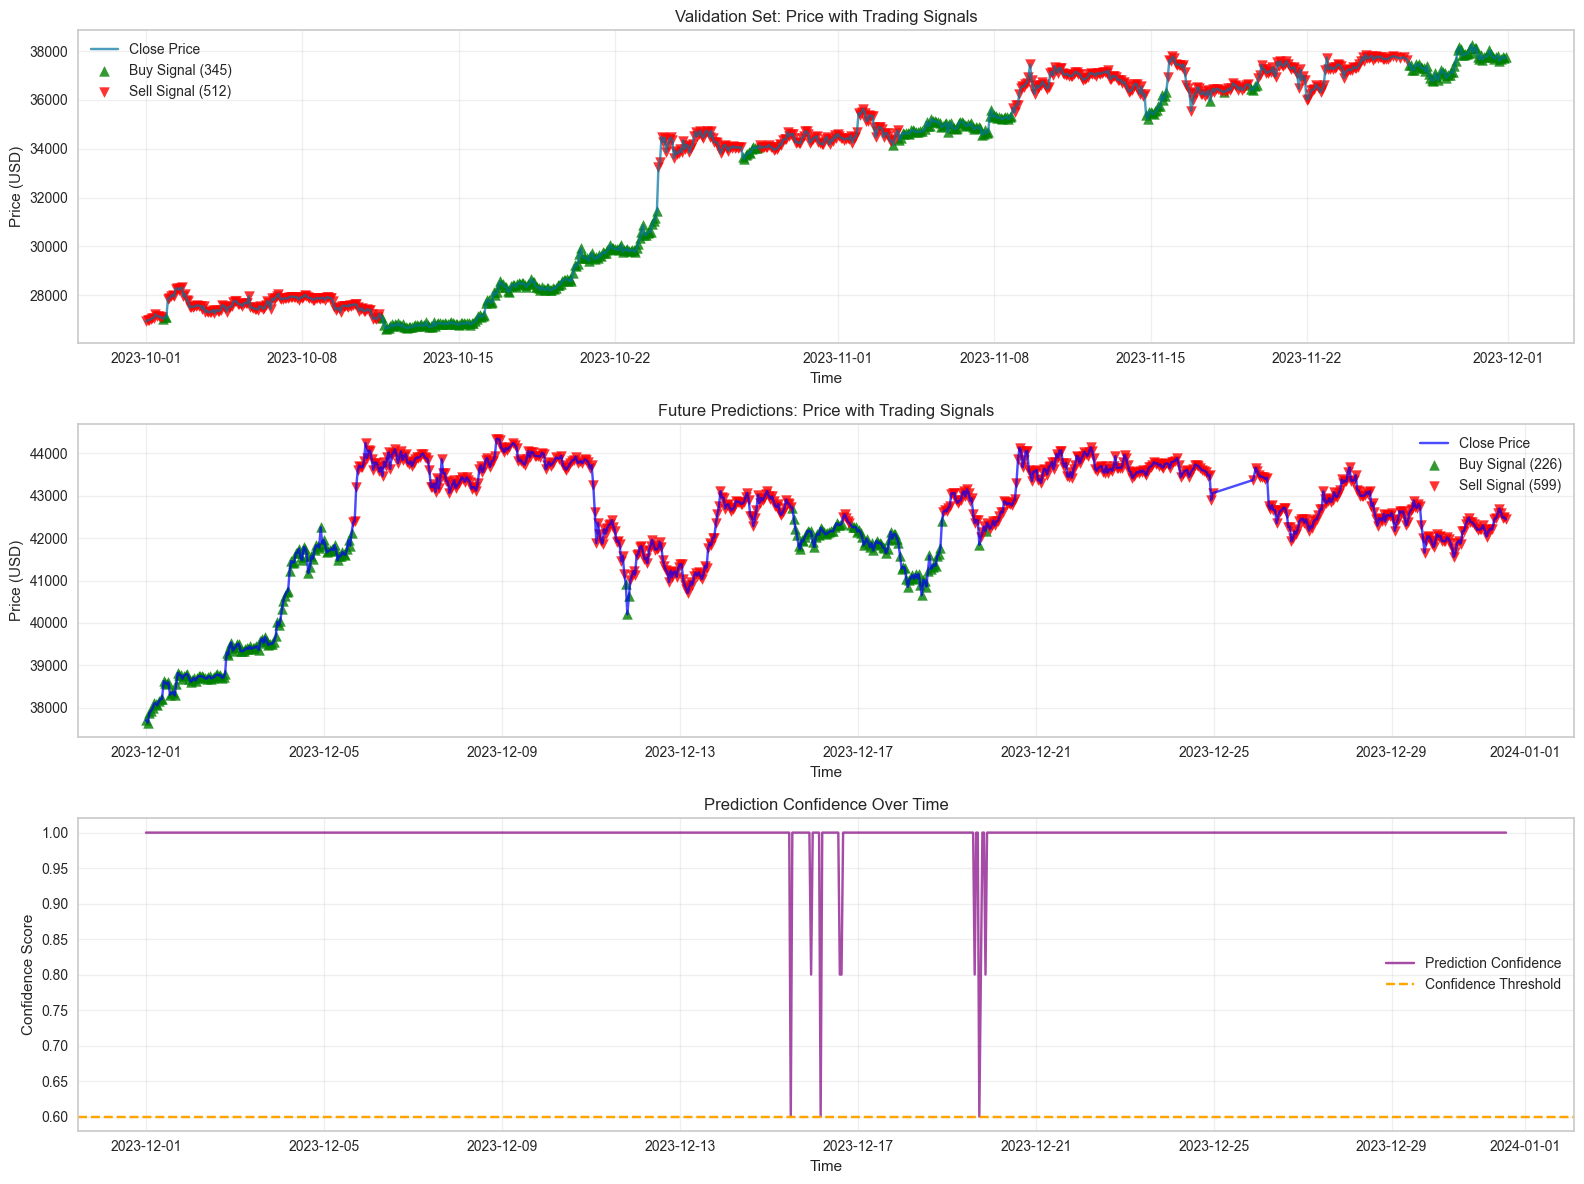

In [14]:
# Visualize predictions and signals over time
plt.figure(figsize=(16, 12))

# Plot 1: Price and predictions for validation set
plt.subplot(3, 1, 1)
val_sample = validation_signals.iloc[::100]  # Sample every 100th point for visualization
plt.plot(val_sample.index, val_sample['Close'], label='Close Price', alpha=0.7)

buy_points = val_sample[val_sample['signal'] == 1]
sell_points = val_sample[val_sample['signal'] == -1]
hold_points = val_sample[val_sample['signal'] == 0]

plt.scatter(buy_points.index, buy_points['Close'], color='green', marker='^', 
           s=50, label=f'Buy Signal ({len(buy_points)})', alpha=0.8)
plt.scatter(sell_points.index, sell_points['Close'], color='red', marker='v', 
           s=50, label=f'Sell Signal ({len(sell_points)})', alpha=0.8)
plt.title('Validation Set: Price with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Future predictions
plt.subplot(3, 1, 2)
fut_sample = future_signals.iloc[::50]  # Sample every 50th point
plt.plot(fut_sample.index, fut_sample['Close'], label='Close Price', alpha=0.7, color='blue')

fut_buy_points = fut_sample[fut_sample['signal'] == 1]
fut_sell_points = fut_sample[fut_sample['signal'] == -1]

plt.scatter(fut_buy_points.index, fut_buy_points['Close'], color='green', marker='^', 
           s=50, label=f'Buy Signal ({len(fut_buy_points)})', alpha=0.8)
plt.scatter(fut_sell_points.index, fut_sell_points['Close'], color='red', marker='v', 
           s=50, label=f'Sell Signal ({len(fut_sell_points)})', alpha=0.8)
plt.title('Future Predictions: Price with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Prediction confidence over time
plt.subplot(3, 1, 3)
if 'confidence' in future_signals.columns:
    plt.plot(fut_sample.index, fut_sample['confidence'], label='Prediction Confidence', 
            color='purple', alpha=0.7)
    plt.axhline(y=0.6, color='orange', linestyle='--', label='Confidence Threshold')
    plt.title('Prediction Confidence Over Time')
    plt.xlabel('Time')
    plt.ylabel('Confidence Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Running fee-aware backtesting for Validation_KNeighborsClassifier...
--------------------------------------------------

=== VALIDATION SET BACKTESTING RESULTS ===
Initial Capital      : $10,000.00
Final Portfolio Value: $12,988.00
Net Profit           : $2,988.00
Total Return         : 29.88%
Sharpe Ratio         : 5.27
Max Drawdown         : 4.38%
Win Rate             : 80.00%
Total Trades         : 15
Avg Trade Return     : 1.86%
Total Fees Paid      : $2838.17
Fee-Aware Exits      : 14
Stop-Loss Exits      : 0


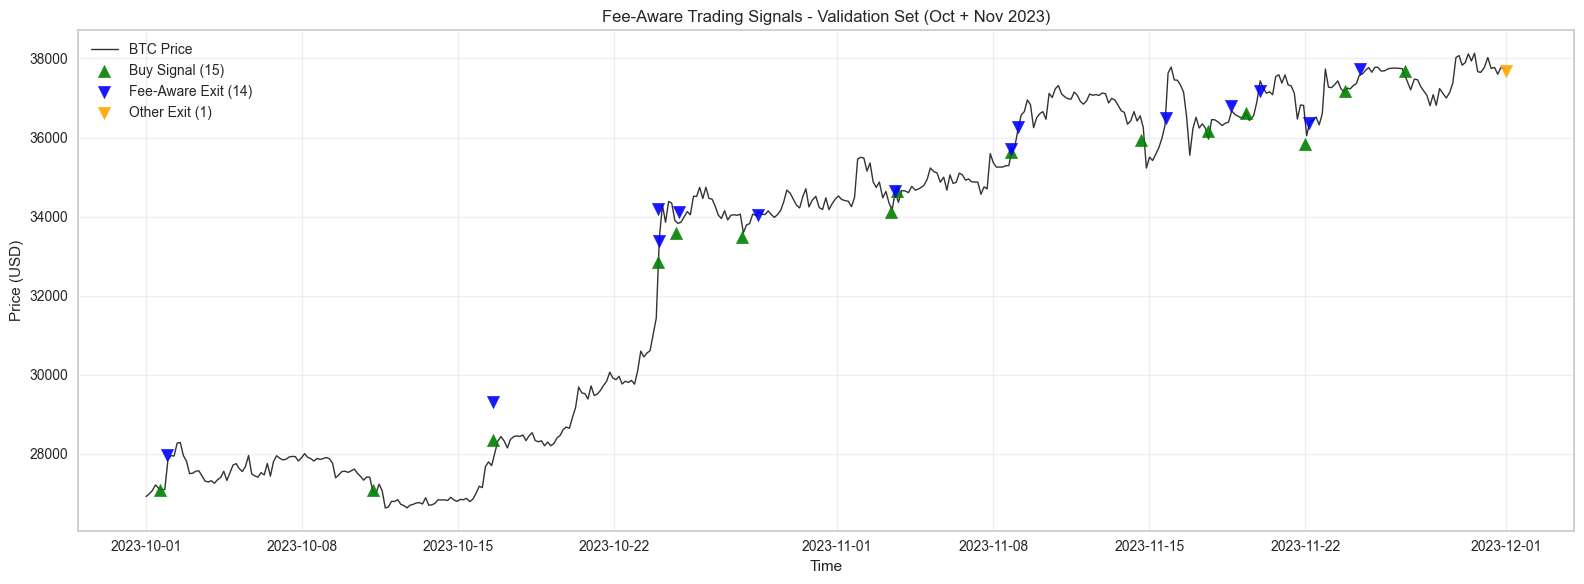

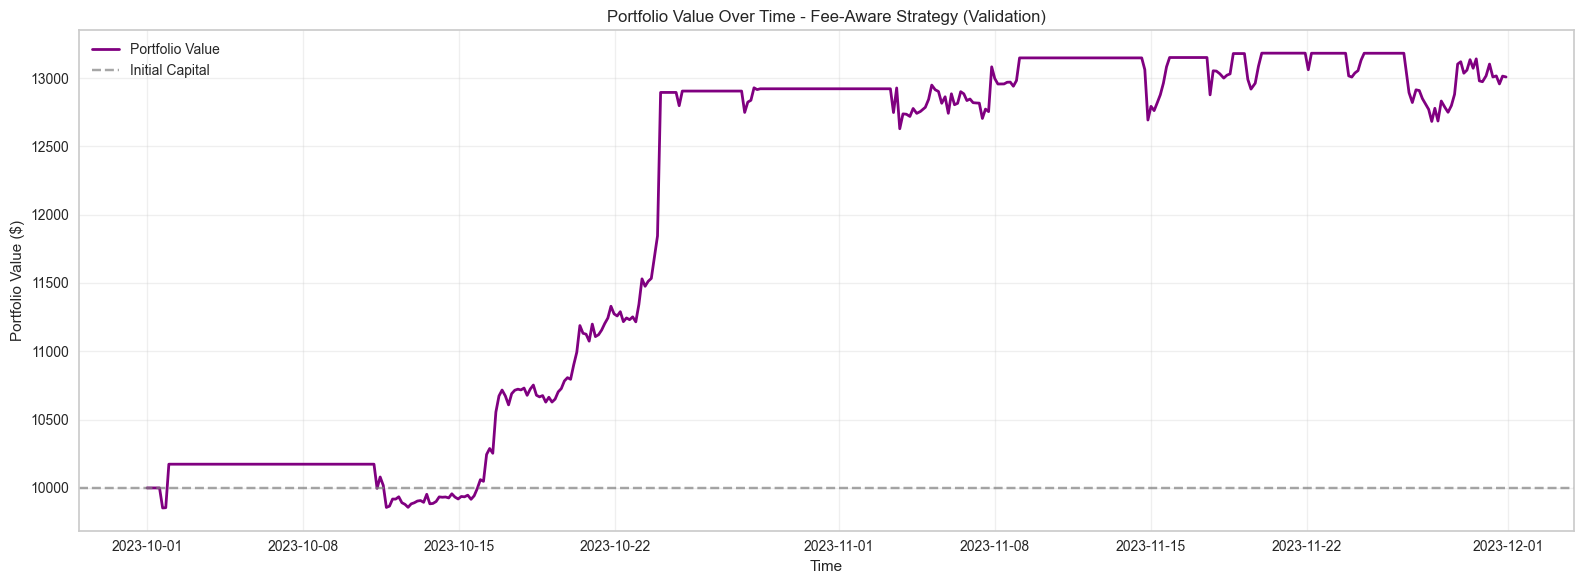


Running fee-aware backtesting for Future_KNeighborsClassifier...
--------------------------------------------------

=== FUTURE PREDICTION SET BACKTESTING RESULTS ===
Initial Capital      : $10,000.00
Final Portfolio Value: $10,692.57
Net Profit           : $692.57
Total Return         : 6.93%
Sharpe Ratio         : 4.04
Max Drawdown         : 8.17%
Win Rate             : 62.50%
Total Trades         : 8
Avg Trade Return     : 0.93%
Total Fees Paid      : $1294.02
Fee-Aware Exits      : 7
Stop-Loss Exits      : 1

=== COMPARISON: VALIDATION vs FUTURE ===
Validation Return    : 29.88%
Future Return        : 6.93%
Validation Trades    : 15
Future Trades        : 8
Validation Win Rate  : 80.00%
Future Win Rate      : 62.50%


In [15]:
# Fee-Aware Backtesting
initial_capital = 10000
fee_pct = 0.0075  # 0.75% fee per trade
stop_loss_pct = 0.05  # 5% stop loss

def fee_aware_backtest(pred_df, model_name='KNeighborsClassifier'):
    """
    Enhanced fee-aware backtesting with stop-loss and intelligent exit logic
    """
    print(f"\nRunning fee-aware backtesting for {model_name}...")
    print("-" * 50)
    
    # Prepare data
    df_backtest = pred_df.copy()
    df_backtest = df_backtest.sort_index()
    
    # Initialize variables
    position = 0
    cash = initial_capital
    trade_log = []
    portfolio_values = []
    in_trade = False
    entry_price = 0
    entry_time = None
    total_invested = 0
    entry_fees = 0

    for i in range(len(df_backtest)):
        row = df_backtest.iloc[i]
        signal = row['prediction_label']
        current_price = row['Close']
        date = row.name

        # Entry Logic: Buy signal
        if signal == 1 and not in_trade:
            available_for_investment = cash
            gross_position_value = available_for_investment / (1 + fee_pct)
            position = gross_position_value / current_price
            entry_fees = gross_position_value * fee_pct
            total_invested = gross_position_value + entry_fees
            entry_price = current_price
            entry_time = date
            cash = 0
            in_trade = True

        # Exit Logic: Fee-aware exit or Stop-loss
        elif in_trade:
            current_value = position * current_price
            price_change = (current_value - total_invested) / total_invested
            
            # Check for stop-loss
            stop_loss_hit = price_change <= -stop_loss_pct
            
            # Fee-aware exit logic
            fee_checker = (current_price - entry_price) / entry_price > fee_pct * 2
            sell_signal = signal == 0
            fee_aware_exit = sell_signal and fee_checker
            
            if fee_aware_exit or stop_loss_hit:
                # Calculate exit with fees
                gross_exit_value = position * current_price
                exit_fees = gross_exit_value * fee_pct
                exit_cash = gross_exit_value - exit_fees
                
                # Calculate PnL
                pnl = exit_cash - total_invested
                return_pct = pnl / total_invested * 100
                
                # Determine exit type
                if stop_loss_hit:
                    exit_type = 'Stop-Loss'
                elif fee_aware_exit:
                    exit_type = 'Fee-Aware Signal Exit'
                else:
                    exit_type = 'Signal Exit'
                
                # Log the trade
                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': date,
                    'Exit Price': round(current_price, 2),
                    'Investment ($)': round(total_invested, 2),
                    'Exit Value ($)': round(exit_cash, 2),
                    'Entry Fees ($)': round(entry_fees, 2),
                    'Exit Fees ($)': round(exit_fees, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Price Change (%)': round((current_price - entry_price) / entry_price * 100, 2),
                    'Fee Checker': fee_checker,
                    'Exit Type': exit_type
                })
                
                cash = exit_cash
                position = 0
                in_trade = False
                total_invested = 0

        # Record portfolio value
        if in_trade:
            current_gross_value = position * current_price
            estimated_exit_fees = current_gross_value * fee_pct
            portfolio_value = current_gross_value - estimated_exit_fees
        else:
            portfolio_value = cash
            
        portfolio_values.append({'timestamp': date, 'portfolio': portfolio_value})

    # Handle remaining position at end
    if in_trade:
        final_price = df_backtest['Close'].iloc[-1]
        gross_exit_value = position * final_price
        exit_fees = gross_exit_value * fee_pct
        exit_cash = gross_exit_value - exit_fees
        pnl = exit_cash - total_invested
        return_pct = pnl / total_invested * 100
        
        trade_log.append({
            'Entry Time': entry_time,
            'Entry Price': round(entry_price, 2),
            'Exit Time': df_backtest.index[-1],
            'Exit Price': round(final_price, 2),
            'Investment ($)': round(total_invested, 2),
            'Exit Value ($)': round(exit_cash, 2),
            'Entry Fees ($)': round(entry_fees, 2),
            'Exit Fees ($)': round(exit_fees, 2),
            'PnL ($)': round(pnl, 2),
            'Return (%)': round(return_pct, 2),
            'Price Change (%)': round((final_price - entry_price) / entry_price * 100, 2),
            'Fee Checker': (final_price - entry_price) / entry_price > fee_pct * 2,
            'Exit Type': 'End of Period'
        })
        cash = exit_cash

    # Convert to DataFrames
    port_df = pd.DataFrame(portfolio_values).set_index('timestamp')
    trade_df = pd.DataFrame(trade_log)
    
    # Calculate metrics
    final_value = cash
    net_profit = final_value - initial_capital
    total_return = (net_profit / initial_capital) * 100
    
    # Portfolio returns for Sharpe ratio
    if len(port_df) > 1:
        returns = port_df['portfolio'].pct_change().dropna()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(365 * 24 * 60) if returns.std() != 0 else 0
        
        # Drawdown calculation
        peak = port_df['portfolio'].cummax()
        drawdown = (port_df['portfolio'] - peak) / peak
        max_drawdown = abs(drawdown.min()) * 100
    else:
        sharpe_ratio = 0
        max_drawdown = 0
    
    # Trade analysis
    if len(trade_df) > 0:
        win_rate = (trade_df['PnL ($)'] > 0).mean() * 100
        trade_count = len(trade_df)
        avg_trade_return = trade_df['Return (%)'].mean()
        total_fees_paid = trade_df['Entry Fees ($)'].sum() + trade_df['Exit Fees ($)'].sum()
        
        # Exit type analysis
        fee_aware_exits = (trade_df['Exit Type'] == 'Fee-Aware Signal Exit').sum()
        stop_loss_exits = (trade_df['Exit Type'] == 'Stop-Loss').sum()
        
    else:
        win_rate = 0
        trade_count = 0
        avg_trade_return = 0
        total_fees_paid = 0
        fee_aware_exits = 0
        stop_loss_exits = 0
    
    return {
        'portfolio_df': port_df,
        'trade_df': trade_df,
        'final_value': final_value,
        'net_profit': net_profit,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'trade_count': trade_count,
        'avg_trade_return': avg_trade_return,
        'total_fees': total_fees_paid,
        'fee_aware_exits': fee_aware_exits,
        'stop_loss_exits': stop_loss_exits
    }

# Run fee-aware backtesting on validation set
if validation_signals is not None and len(validation_signals) > 0:
    validation_backtest = fee_aware_backtest(validation_signals, 'Validation_KNeighborsClassifier')
    
    print(f"\n=== VALIDATION SET BACKTESTING RESULTS ===")
    print(f"Initial Capital      : ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${validation_backtest['final_value']:,.2f}")
    print(f"Net Profit           : ${validation_backtest['net_profit']:,.2f}")
    print(f"Total Return         : {validation_backtest['total_return']:.2f}%")
    print(f"Sharpe Ratio         : {validation_backtest['sharpe_ratio']:.2f}")
    print(f"Max Drawdown         : {validation_backtest['max_drawdown']:.2f}%")
    print(f"Win Rate             : {validation_backtest['win_rate']:.2f}%")
    print(f"Total Trades         : {validation_backtest['trade_count']}")
    print(f"Avg Trade Return     : {validation_backtest['avg_trade_return']:.2f}%")
    print(f"Total Fees Paid      : ${validation_backtest['total_fees']:.2f}")
    print(f"Fee-Aware Exits      : {validation_backtest['fee_aware_exits']}")
    print(f"Stop-Loss Exits      : {validation_backtest['stop_loss_exits']}")
    
    # --- Plot Trade Signals for Validation (FIXED ALIGNMENT) ---
    plt.figure(figsize=(16, 6))
    
    # Use consistent sampling for both price line and trading signals
    sample_step = 200
    val_sample = validation_signals.iloc[::sample_step]
    
    # Plot price line
    plt.plot(val_sample.index, val_sample['Close'], label='BTC Price', linewidth=1, alpha=0.8, color='black')
    
    trade_df = validation_backtest['trade_df']
    if len(trade_df) > 0:
        # Filter trade signals to only show those within the sampled timeframe
        sample_start = val_sample.index[0]
        sample_end = val_sample.index[-1]
        
        # Convert trade times to datetime for filtering
        entry_times = pd.to_datetime(trade_df['Entry Time'])
        exit_times = pd.to_datetime(trade_df['Exit Time'])
        
        # Filter trades that fall within the sampled period
        trade_mask = (entry_times >= sample_start) & (entry_times <= sample_end)
        filtered_trades = trade_df[trade_mask].copy()
        
        if len(filtered_trades) > 0:
            entry_times_filtered = pd.to_datetime(filtered_trades['Entry Time'])
            exit_times_filtered = pd.to_datetime(filtered_trades['Exit Time'])
            entry_prices_filtered = filtered_trades['Entry Price']
            exit_prices_filtered = filtered_trades['Exit Price']
            
            # Color code exits by type
            fee_aware_mask = filtered_trades['Exit Type'] == 'Fee-Aware Signal Exit'
            stop_loss_mask = filtered_trades['Exit Type'] == 'Stop-Loss'
            other_mask = ~(fee_aware_mask | stop_loss_mask)
            
            # Plot entry points
            plt.scatter(entry_times_filtered, entry_prices_filtered, marker='^', color='green', s=80, 
                       label=f'Buy Signal ({len(entry_times_filtered)})', alpha=0.9, zorder=5)
            
            # Plot exit points by type
            if fee_aware_mask.any():
                plt.scatter(exit_times_filtered[fee_aware_mask], exit_prices_filtered[fee_aware_mask],
                            marker='v', color='blue', s=80, 
                            label=f'Fee-Aware Exit ({fee_aware_mask.sum()})', alpha=0.9, zorder=5)
            if stop_loss_mask.any():
                plt.scatter(exit_times_filtered[stop_loss_mask], exit_prices_filtered[stop_loss_mask], 
                            marker='v', color='red', s=80, 
                            label=f'Stop-Loss Exit ({stop_loss_mask.sum()})', alpha=0.9, zorder=5)
            if other_mask.any():
                plt.scatter(exit_times_filtered[other_mask], exit_prices_filtered[other_mask], 
                            marker='v', color='orange', s=80, 
                            label=f'Other Exit ({other_mask.sum()})', alpha=0.9, zorder=5)
        else:
            plt.text(0.5, 0.95, 'No trades in sampled period', transform=plt.gca().transAxes, 
                    ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    plt.title('Fee-Aware Trading Signals - Validation Set (Oct + Nov 2023)')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --- Plot Portfolio Value ---
    plt.figure(figsize=(16, 6))
    port_df = validation_backtest['portfolio_df']
    sample_port = port_df.iloc[::sample_step]
    plt.plot(sample_port.index, sample_port['portfolio'], linewidth=2, 
             label='Portfolio Value', color='purple')
    plt.axhline(y=initial_capital, color='gray', linestyle='--', 
                label='Initial Capital', alpha=0.7)
    plt.title('Portfolio Value Over Time - Fee-Aware Strategy (Validation)')
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run fee-aware backtesting on future prediction set
if future_signals is not None and len(future_signals) > 0:
    future_backtest = fee_aware_backtest(future_signals, 'Future_KNeighborsClassifier')
    
    print(f"\n=== FUTURE PREDICTION SET BACKTESTING RESULTS ===")
    print(f"Initial Capital      : ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${future_backtest['final_value']:,.2f}")
    print(f"Net Profit           : ${future_backtest['net_profit']:,.2f}")
    print(f"Total Return         : {future_backtest['total_return']:.2f}%")
    print(f"Sharpe Ratio         : {future_backtest['sharpe_ratio']:.2f}")
    print(f"Max Drawdown         : {future_backtest['max_drawdown']:.2f}%")
    print(f"Win Rate             : {future_backtest['win_rate']:.2f}%")
    print(f"Total Trades         : {future_backtest['trade_count']}")
    print(f"Avg Trade Return     : {future_backtest['avg_trade_return']:.2f}%")
    print(f"Total Fees Paid      : ${future_backtest['total_fees']:.2f}")
    print(f"Fee-Aware Exits      : {future_backtest['fee_aware_exits']}")
    print(f"Stop-Loss Exits      : {future_backtest['stop_loss_exits']}")
    
    # Save detailed trade logs
    val_trade_log = validation_backtest['trade_df']
    future_trade_log = future_backtest['trade_df']
    
    # Store results for final summary
    backtest_results = {
        'validation': validation_backtest,
        'future': future_backtest
    }
    
    print(f"\n=== COMPARISON: VALIDATION vs FUTURE ===")
    print(f"Validation Return    : {validation_backtest['total_return']:.2f}%")
    print(f"Future Return        : {future_backtest['total_return']:.2f}%")
    print(f"Validation Trades    : {validation_backtest['trade_count']}")
    print(f"Future Trades        : {future_backtest['trade_count']}")
    print(f"Validation Win Rate  : {validation_backtest['win_rate']:.2f}%")
    print(f"Future Win Rate      : {future_backtest['win_rate']:.2f}%")

else:
    print("No validation data available for backtesting.")

In [16]:
val_trade_log

,Entry Time,Entry Price,Exit Time,Exit Price,Investment ($),Exit Value ($),Entry Fees ($),Exit Fees ($),PnL ($),Return (%),Price Change (%),Fee Checker,Exit Type
0,2023-10-01 15:00:00,27087.8,2023-10-01 22:17:00,27975.100000,10000.00,10173.80,74.44,76.88,173.80,1.74,3.28,True,Fee-Aware Signal Exit
1,2023-10-11 04:46:00,27078.6,2023-10-16 13:29:00,29311.100000,10173.80,10848.63,75.74,81.98,674.82,6.63,8.24,True,Fee-Aware Signal Exit
2,2023-10-16 13:40:00,28361.7,2023-10-23 22:42:00,34189.800000,10848.63,12883.22,80.76,97.35,2034.60,18.75,20.55,True,Fee-Aware Signal Exit
3,2023-10-23 23:10:00,32857.4,2023-10-24 00:31:00,33383.500000,12883.22,12894.62,95.90,97.44,11.40,0.09,1.60,True,Fee-Aware Signal Exit
4,2023-10-24 18:09:00,33577.6,2023-10-24 21:56:00,34111.600000,12894.62,12904.66,95.99,97.52,10.04,0.08,1.59,True,Fee-Aware Signal Exit
5,2023-10-27 17:07:00,33495.4,2023-10-28 10:42:00,34045.600000,12904.66,12921.35,96.06,97.64,16.69,0.13,1.64,True,Fee-Aware Signal Exit
6,2023-11-03 10:15:00,34116.1,2023-11-03 14:25:00,34647.800000,12921.35,12927.35,96.19,97.69,6.00,0.05,1.56,True,Fee-Aware Signal Exit
7,2023-11-03 16:33:00,34650.3,2023-11-08 19:17:00,35701.700000,12927.35,13121.30,96.23,99.15,193.95,1.50,3.03,True,Fee-Aware Signal Exit
8,2023-11-08 19:18:00,35644.7,2023-11-09 02:24:00,36255.300000,13121.30,13147.37,97.68,99.35,26.07,0.20,1.71,True,Fee-Aware Signal Exit
9,2023-11-14 15:34:00,35946.1,2023-11-15 18:06:00,36497.100000,13147.37,13150.16,97.87,99.37,2.79,0.02,1.53,True,Fee-Aware Signal Exit


In [15]:
# Monthly Trading Signal Pattern Analysis
print("="*80)
print("MONTHLY TRADING SIGNAL PATTERN ANALYSIS")
print("="*80)

def analyze_signal_clustering(signals_df, month_name):
    """Analyze clustering patterns in trading signals"""
    if signals_df.empty:
        return {
            'month': month_name,
            'total_signals': 0,
            'buy_signals': 0,
            'sell_signals': 0,
            'clustering_score': 0,
            'avg_gap_hours': 0,
            'clustered_signals': 0
        }
    
    # Calculate time gaps between consecutive signals
    signals_df = signals_df.sort_values('timestamp')
    signals_df['time_gap'] = signals_df['timestamp'].diff()
    signals_df['gap_hours'] = signals_df['time_gap'].dt.total_seconds() / 3600
    
    # Define clustering (signals within 24 hours)
    clustered = (signals_df['gap_hours'] < 24) & (signals_df['gap_hours'] > 0)
    
    buy_signals = len(signals_df[signals_df['signal'] == 'BUY'])
    sell_signals = len(signals_df[signals_df['signal'] == 'SELL'])
    
    return {
        'month': month_name,
        'total_signals': len(signals_df),
        'buy_signals': buy_signals,
        'sell_signals': sell_signals,
        'clustering_score': clustered.sum() / len(signals_df) if len(signals_df) > 1 else 0,
        'avg_gap_hours': signals_df['gap_hours'].mean() if len(signals_df) > 1 else 0,
        'clustered_signals': clustered.sum()
    }

# Analyze each month
clustering_results = []
all_monthly_signals = {}

for month in ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
              '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']:
    
    print(f"\nProcessing {month}...")
    
    # Load month data
    try:
        month_symbol = f"BTCUSD_1min_{month.replace('-', '_')}"
        month_data = load_monthly_data(month_symbol)
        print(f"  Data loaded: {len(month_data):,} records")
    except Exception as e:
        print(f"   Failed to load data for {month}: {e}")
        continue
    
    # Generate predictions for this month
    try:
        month_predictions = generate_predictions(knn_model, month_data, feature_columns, model_type=model_type)
        
        # Generate trading signals with confidence threshold
        confidence_threshold = 0.7
        signals = []
        position = None
        
        for idx, row in month_predictions.iterrows():
            prediction = row['prediction_label'] 
            confidence = row.get('prediction_score', 0.5)
            
            if confidence >= confidence_threshold:
                if prediction == 1 and position != 'long':  # Bull market prediction
                    signals.append({
                        'timestamp': idx,
                        'signal': 'BUY',
                        'price': row['Close'],
                        'confidence': confidence
                    })
                    position = 'long'
                elif prediction == 0 and position != 'short':  # Bear market prediction
                    signals.append({
                        'timestamp': idx,
                        'signal': 'SELL',
                        'price': row['Close'],
                        'confidence': confidence
                    })
                    position = 'short'
        
        signals_df = pd.DataFrame(signals)
        all_monthly_signals[month] = signals_df
        
        # Analyze clustering for this month
        clustering_result = analyze_signal_clustering(signals_df, month)
        clustering_results.append(clustering_result)
        
        print(f"   Generated {len(signals_df)} trading signals")
        print(f"     Buy signals: {clustering_result['buy_signals']}")
        print(f"     Sell signals: {clustering_result['sell_signals']}")
        print(f"     Clustering score: {clustering_result['clustering_score']:.2%}")
        
    except Exception as e:
        print(f"   Error processing {month}: {str(e)}")
        clustering_results.append({
            'month': month, 'total_signals': 0, 'buy_signals': 0, 
            'sell_signals': 0, 'clustering_score': 0, 'avg_gap_hours': 0, 'clustered_signals': 0
        })

print(f"\n{'='*80}")
print("CLUSTERING ANALYSIS SUMMARY")
print(f"{'='*80}")

# Create summary DataFrame
clustering_df = pd.DataFrame(clustering_results)
print(clustering_df.to_string(index=False))

# Overall statistics
print(f"\n OVERALL CLUSTERING STATISTICS:")
print(f"Average clustering score: {clustering_df['clustering_score'].mean():.2%}")
print(f"Months with high clustering (>30%): {sum(clustering_df['clustering_score'] > 0.3)} out of {len(clustering_df)}")
print(f"Total signals generated: {clustering_df['total_signals'].sum():,}")
print(f"Average signals per month: {clustering_df['total_signals'].mean():.1f}")
print(f"Average time gap between signals: {clustering_df['avg_gap_hours'].mean():.1f} hours")

print(f"\n Monthly signal pattern analysis completed!")

MONTHLY TRADING SIGNAL PATTERN ANALYSIS

Processing 2023-01...
Loading data for: BTCUSD_1min_2023_01
Loaded from ArcticDB - Data shape: (38013, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
  Data loaded: 38,013 records
Generating predictions using pycaret model...
Feature data shape: (38013, 20)
PyCaret prediction completed successfully
   Generated 5 trading signals
     Buy signals: 2
     Sell signals: 3
     Clustering score: 0.00%

Processing 2023-02...
Loading data for: BTCUSD_1min_2023_02
Loaded from ArcticDB - Data shape: (38508, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'ma


MONTH-BY-MONTH TRADING SIGNAL VISUALIZATION (ENHANCED WITH PRICE DATA)
 Visualizing 12 months of trading signals with price overlay...

=== 2023-01 ===
Loading data for: BTCUSD_1min_2023_01
Loaded from ArcticDB - Data shape: (38013, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
 Loaded 38,013 complete price points, sampling 634 for visualization
Period: 2023-01-06 20:10:00 to 2023-01-30 19:09:00
Total signals: 5
Buy signals: 2 (40.0%)
Sell signals: 3 (60.0%)
Price range: $16,952.90 - $22,929.50
Start price: $16,952.90
End price: $22,929.50
Price change: +35.25%


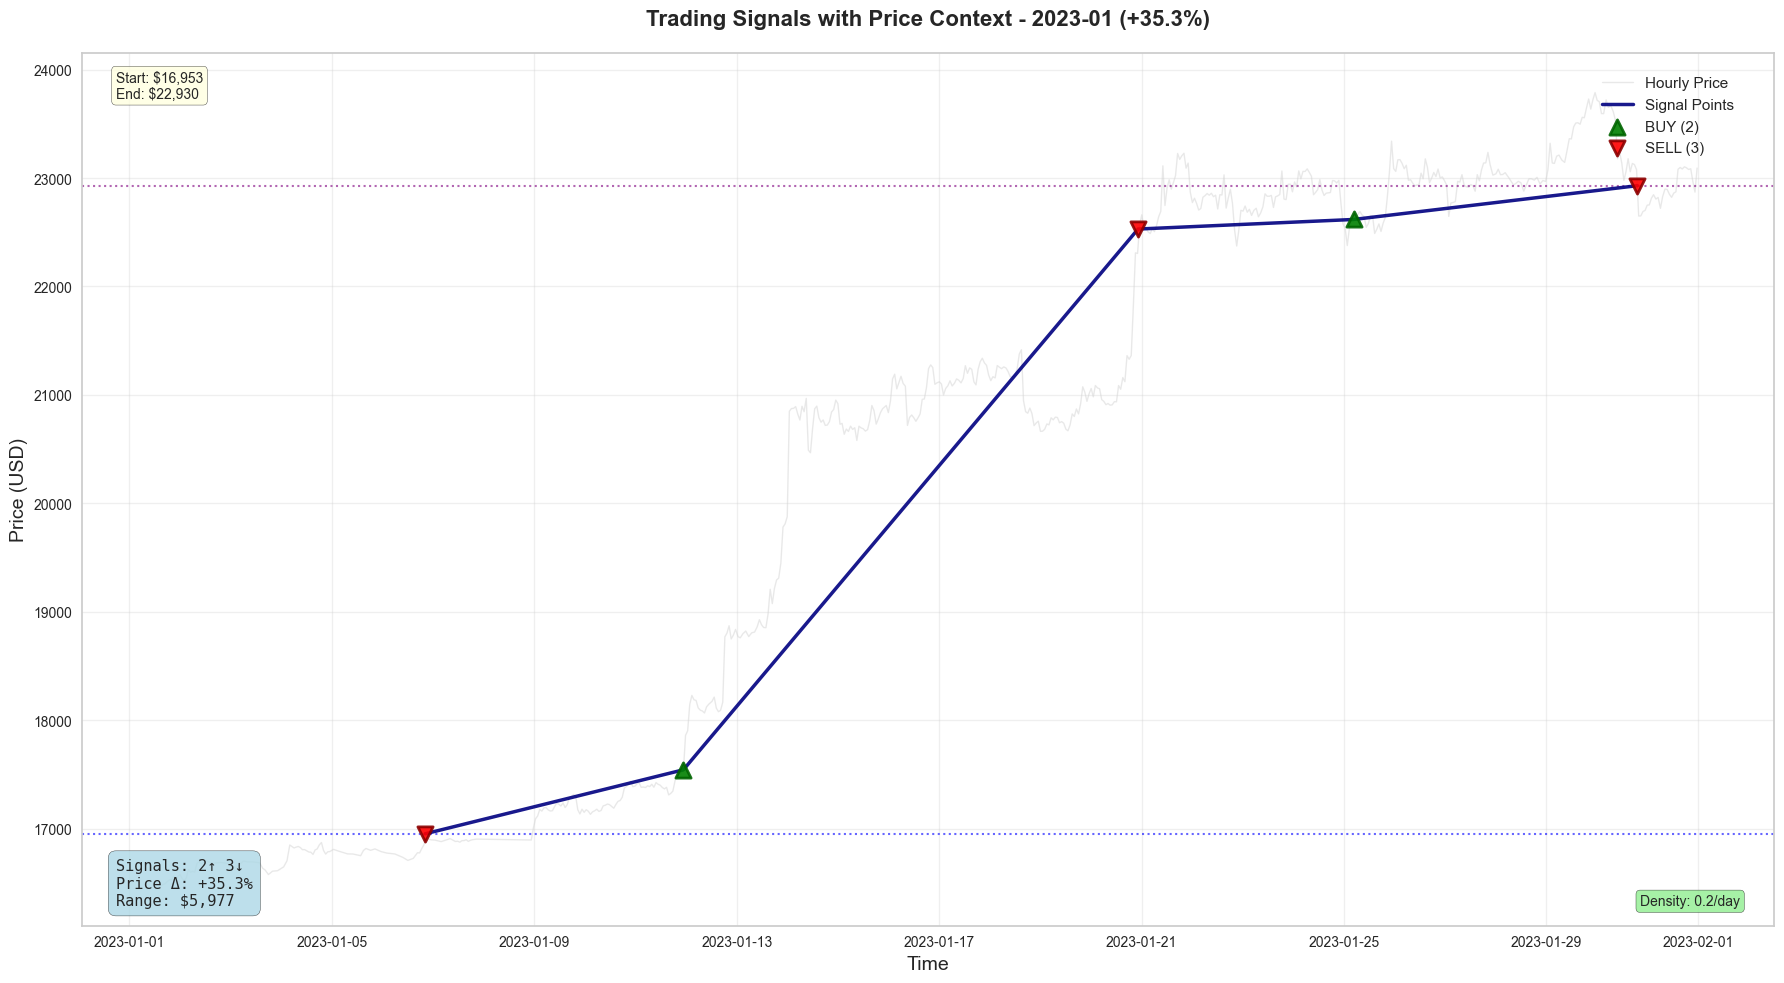


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-01-06 20:10   SELL $16952.90   0.80     Base
  2     2023-01-11 22:43    BUY $17543.50   1.00   +3.48%
  3     2023-01-20 22:20   SELL $22529.50   0.80  +28.42%
  4     2023-01-25 04:32    BUY $22617.80   1.00   +0.39%
  5     2023-01-30 19:09   SELL $22929.50   0.80   +1.38%

 SIGNAL TRANSITIONS:
  SELL→BUY: 2 times
  BUY→SELL: 2 times
--------------------------------------------------------------------------------

=== 2023-02 ===
Loading data for: BTCUSD_1min_2023_02
Loaded from ArcticDB - Data shape: (38508, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hi

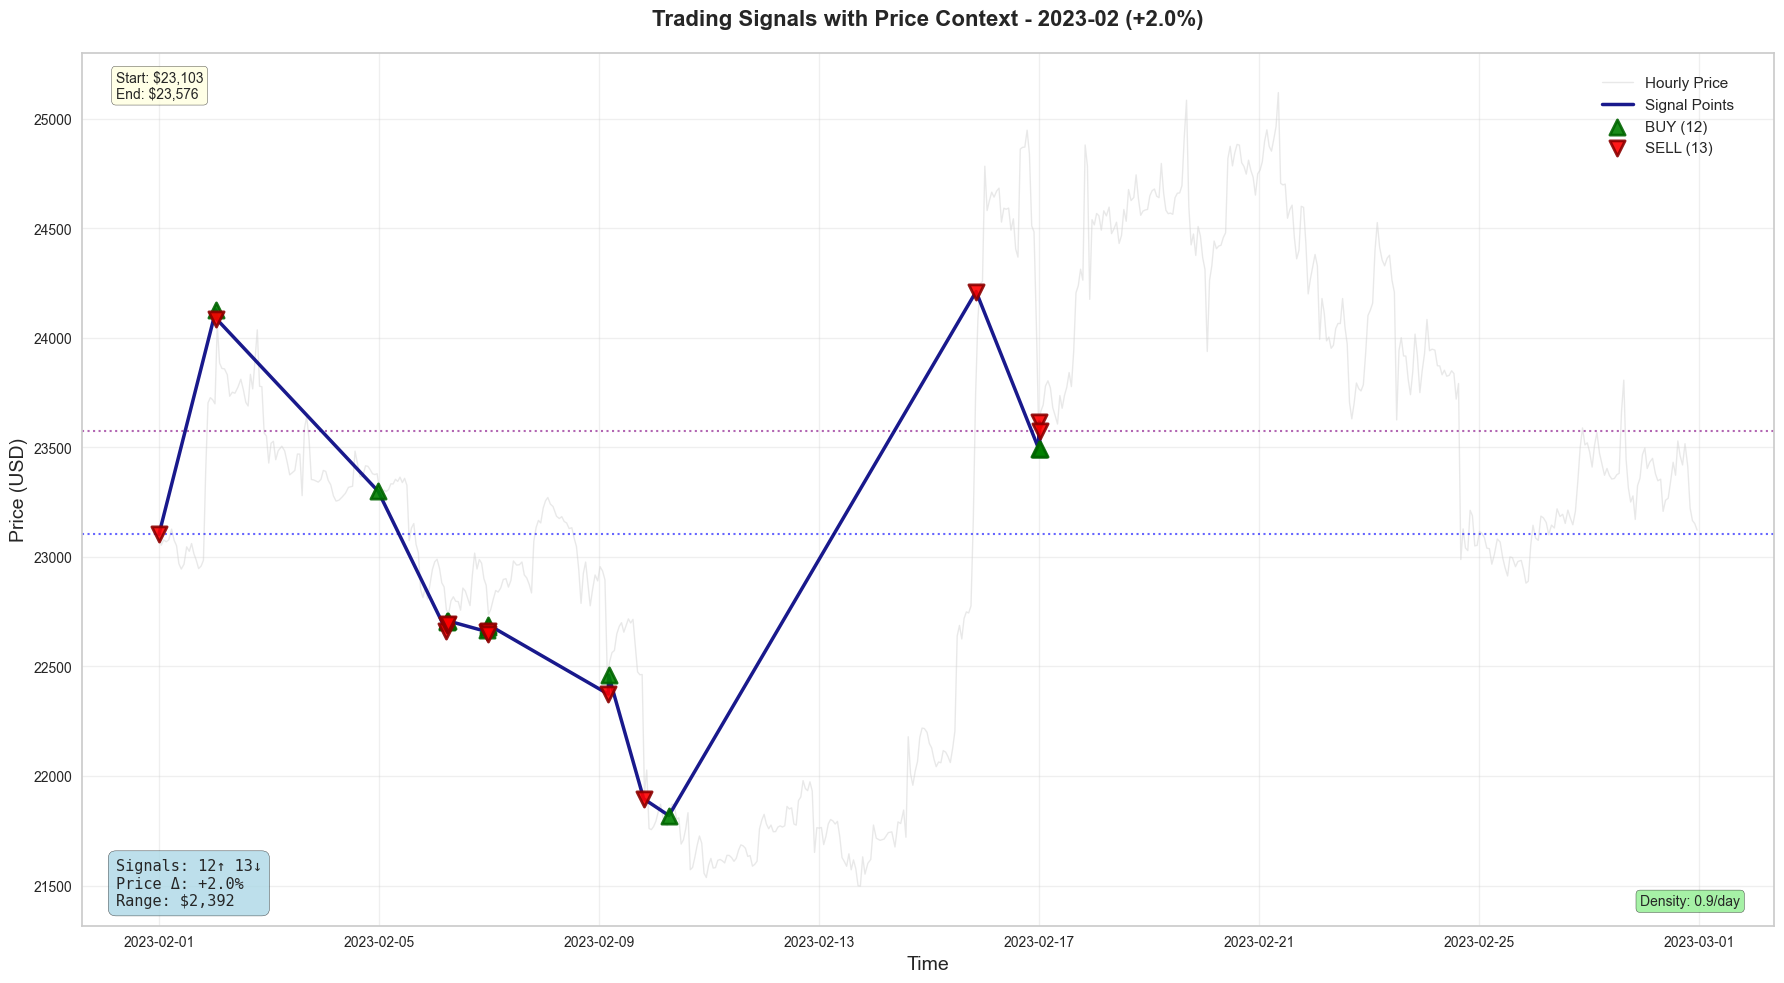


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-02-01 00:00   SELL $23103.00   1.00     Base
  2     2023-02-02 00:52    BUY $24127.40   0.80   +4.43%
  3     2023-02-02 01:05   SELL $24086.80   0.80   -0.17%
  4     2023-02-04 23:38    BUY $23300.00   0.80   -3.27%
  5     2023-02-06 05:27   SELL $22661.90   1.00   -2.74%
  6     2023-02-06 05:36    BUY $22702.00   0.80   +0.18%
  7     2023-02-06 05:37   SELL $22688.60   1.00   -0.06%
  8     2023-02-06 05:41    BUY $22709.60   1.00   +0.09%
  9     2023-02-06 06:16   SELL $22692.50   1.00   -0.08%
 10     2023-02-06 06:20    BUY $22707.50   1.00   +0.07%
 11     2023-02-06 23:16   SELL $22658.30   0.80   -0.22%
 12     2023-02-06 23:22    BUY $22668.50   1.00   +0.05%
 13     2023-02-06 23:23   SELL $22

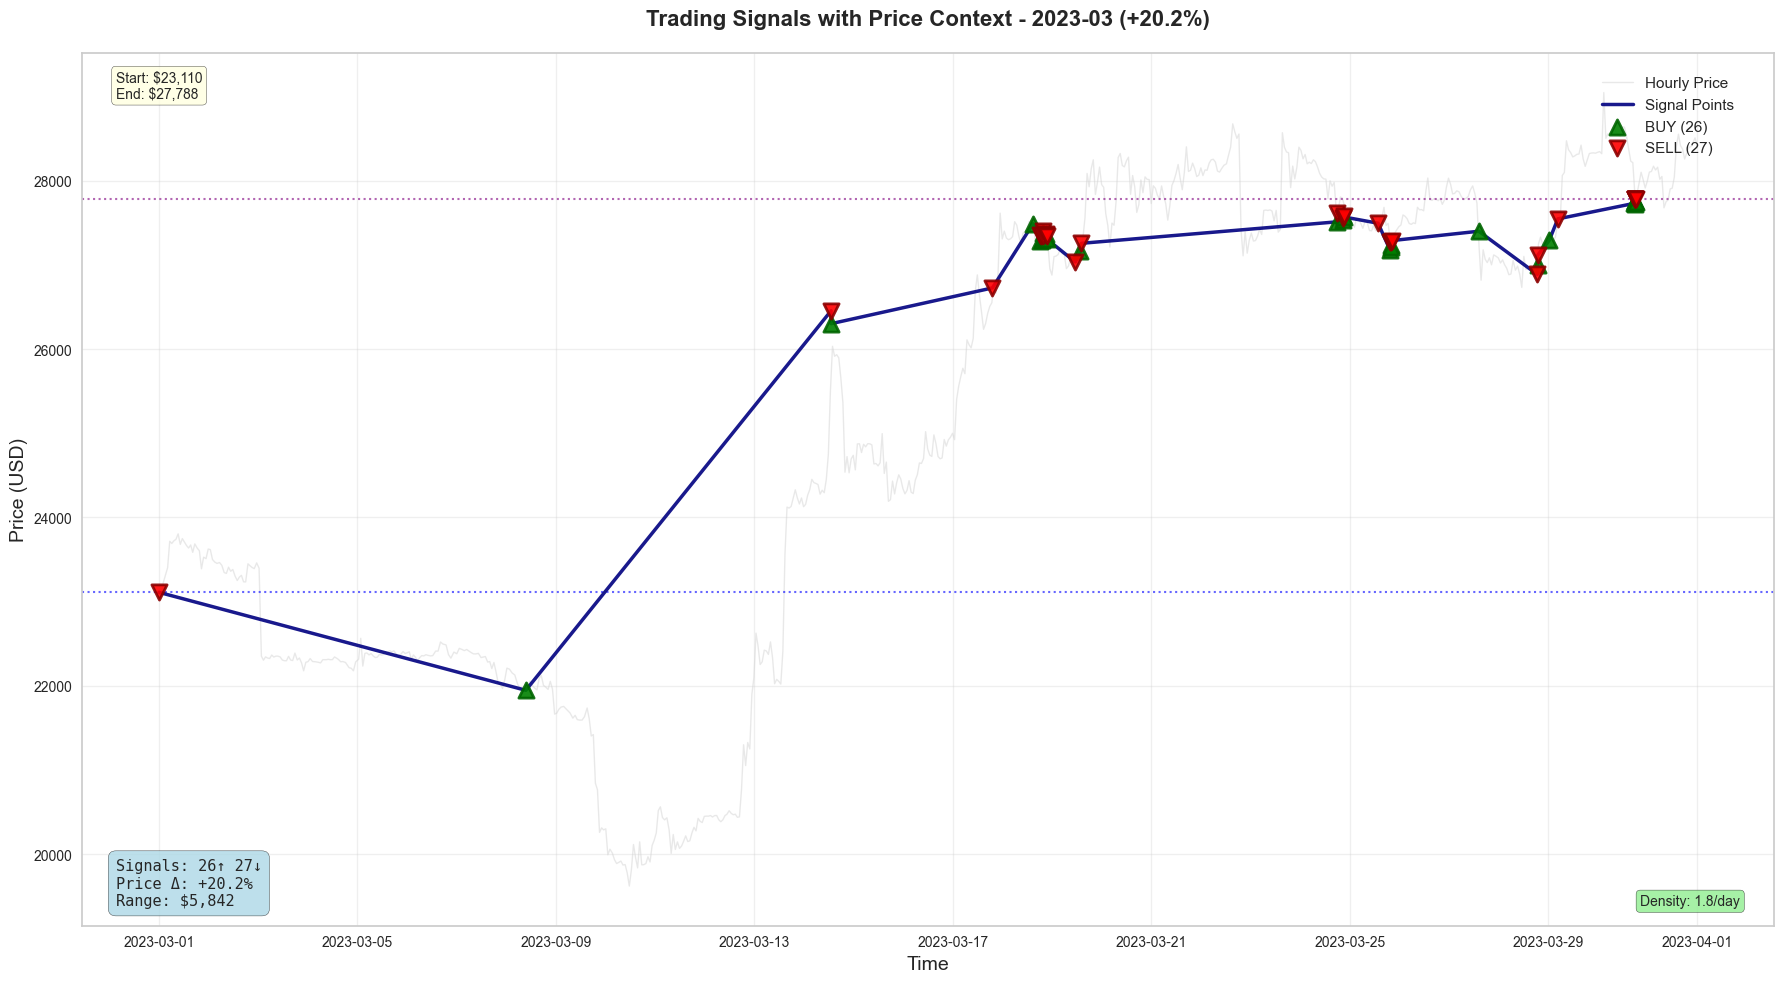


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-03-01 00:00   SELL $23110.50   1.00     Base
  2     2023-03-08 09:26    BUY $21946.30   0.80   -5.04%
  3     2023-03-14 13:04   SELL $26456.20   0.80  +20.55%
  4     2023-03-14 13:06    BUY $26302.50   0.80   -0.58%
  5     2023-03-17 19:05   SELL $26727.20   1.00   +1.61%
  6     2023-03-18 14:43    BUY $27489.60   1.00   +2.85%
  7     2023-03-18 18:12   SELL $27351.00   0.80   -0.50%
  8     2023-03-18 18:15    BUY $27287.60   0.80   -0.23%
  9     2023-03-18 18:21   SELL $27349.60   0.80   +0.23%
 10     2023-03-18 19:16    BUY $27294.90   1.00   -0.20%
 11     2023-03-18 19:25   SELL $27339.00   0.80   +0.16%
 12     2023-03-18 19:27    BUY $27385.50   0.80   +0.17%
 13     2023-03-18 19:41   SELL $27

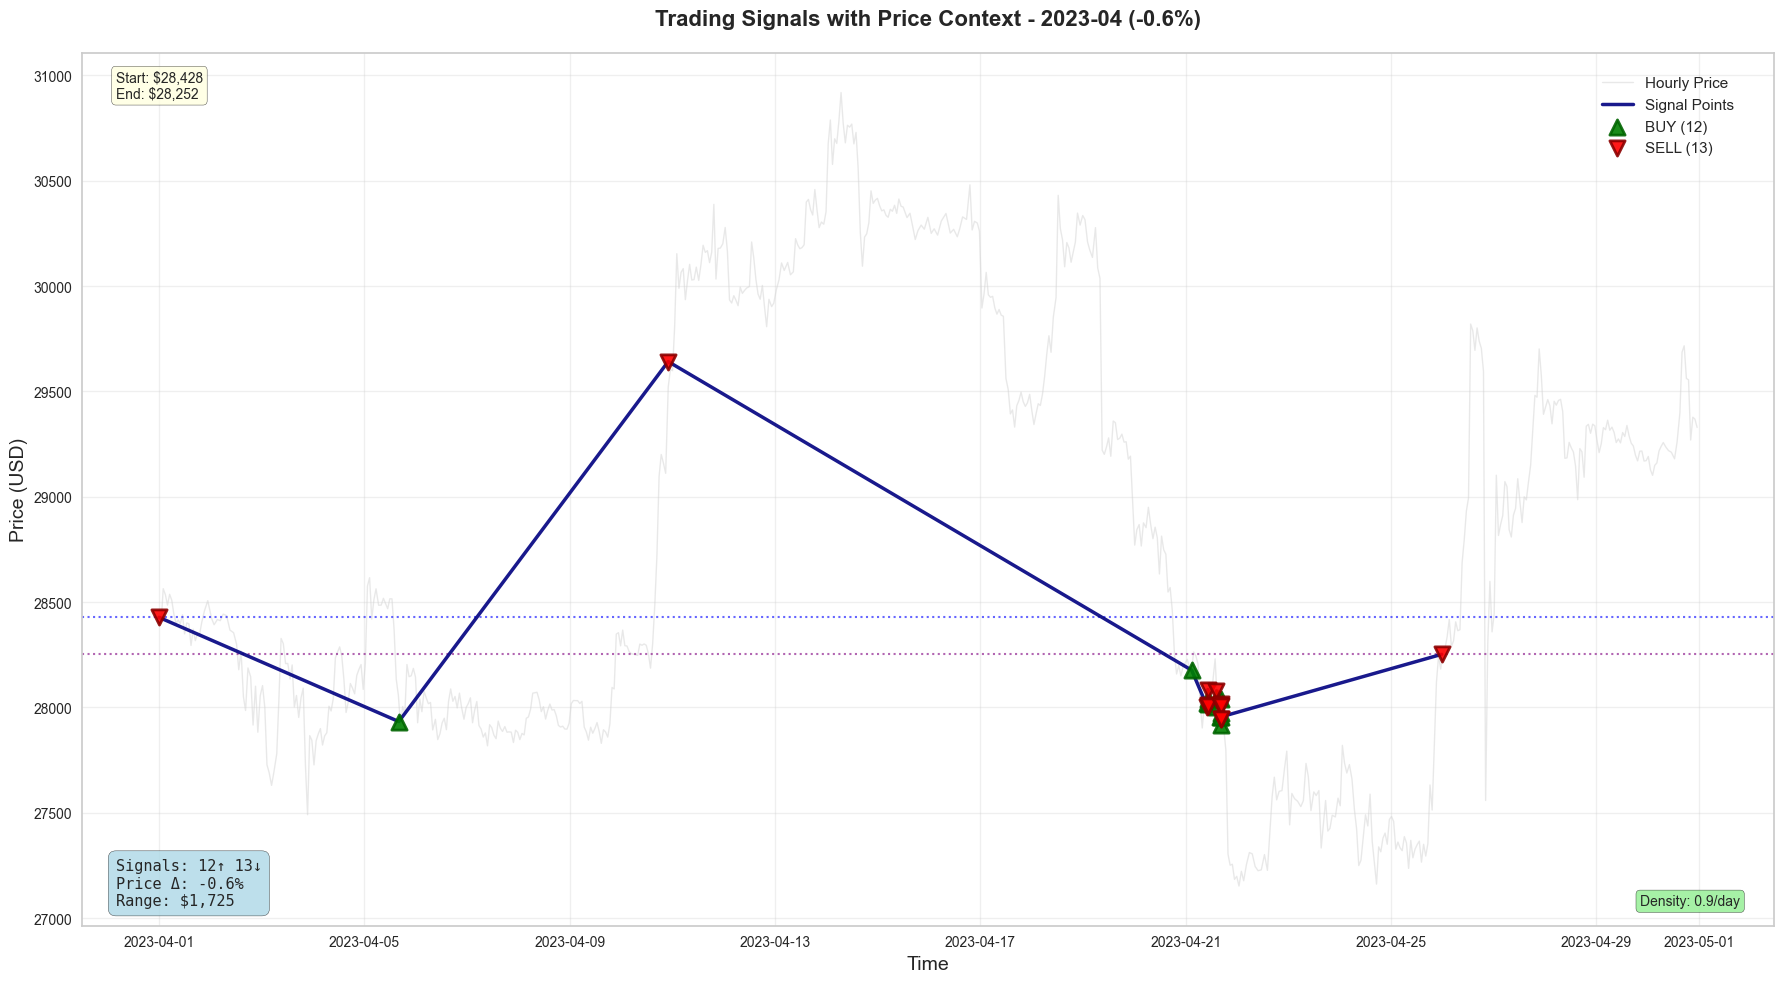


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-04-01 00:00   SELL $28427.60   1.00     Base
  2     2023-04-05 16:08    BUY $27932.90   0.80   -1.74%
  3     2023-04-10 22:03   SELL $29641.60   1.00   +6.12%
  4     2023-04-21 02:46    BUY $28176.70   0.80   -4.94%
  5     2023-04-21 10:02   SELL $28003.80   0.80   -0.61%
  6     2023-04-21 10:07    BUY $28022.10   0.80   +0.07%
  7     2023-04-21 10:11   SELL $28009.90   0.80   -0.04%
  8     2023-04-21 10:14    BUY $28040.20   0.80   +0.11%
  9     2023-04-21 10:18   SELL $28084.70   1.00   +0.16%
 10     2023-04-21 10:34    BUY $28016.60   0.80   -0.24%
 11     2023-04-21 10:35   SELL $28005.80   1.00   -0.04%
 12     2023-04-21 14:16    BUY $28001.00   1.00   -0.02%
 13     2023-04-21 14:18   SELL $28

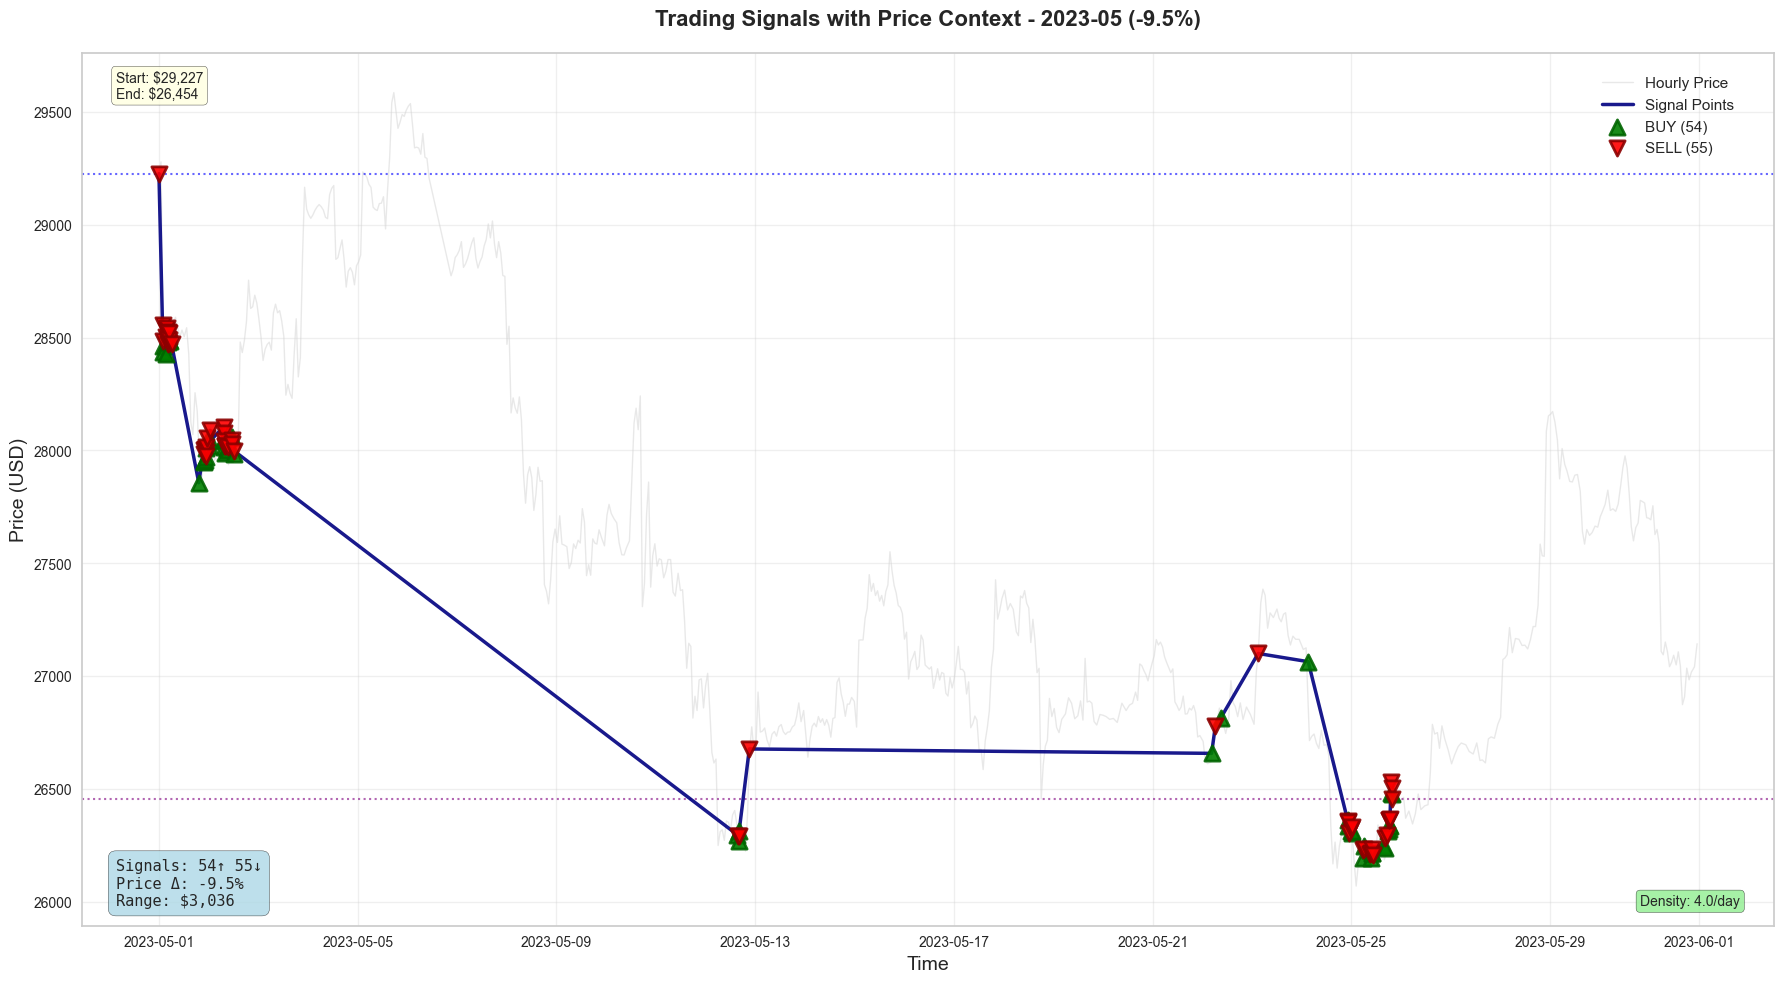


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-05-01 00:00   SELL $29226.80   1.00     Base
  2     2023-05-01 01:58    BUY $28460.40   0.80   -2.62%
  3     2023-05-01 01:59   SELL $28486.60   0.80   +0.09%
  4     2023-05-01 02:00    BUY $28434.20   1.00   -0.18%
  5     2023-05-01 02:02   SELL $28553.90   1.00   +0.42%
  6     2023-05-01 03:15    BUY $28426.30   1.00   -0.45%
  7     2023-05-01 03:18   SELL $28501.70   0.80   +0.27%
  8     2023-05-01 03:35    BUY $28531.80   0.80   +0.11%
  9     2023-05-01 03:36   SELL $28534.20   0.80   +0.01%
 10     2023-05-01 03:56    BUY $28533.50   0.80   -0.00%
 11     2023-05-01 04:01   SELL $28542.10   1.00   +0.03%
 12     2023-05-01 04:10    BUY $28536.40   0.80   -0.02%
 13     2023-05-01 04:16   SELL $28

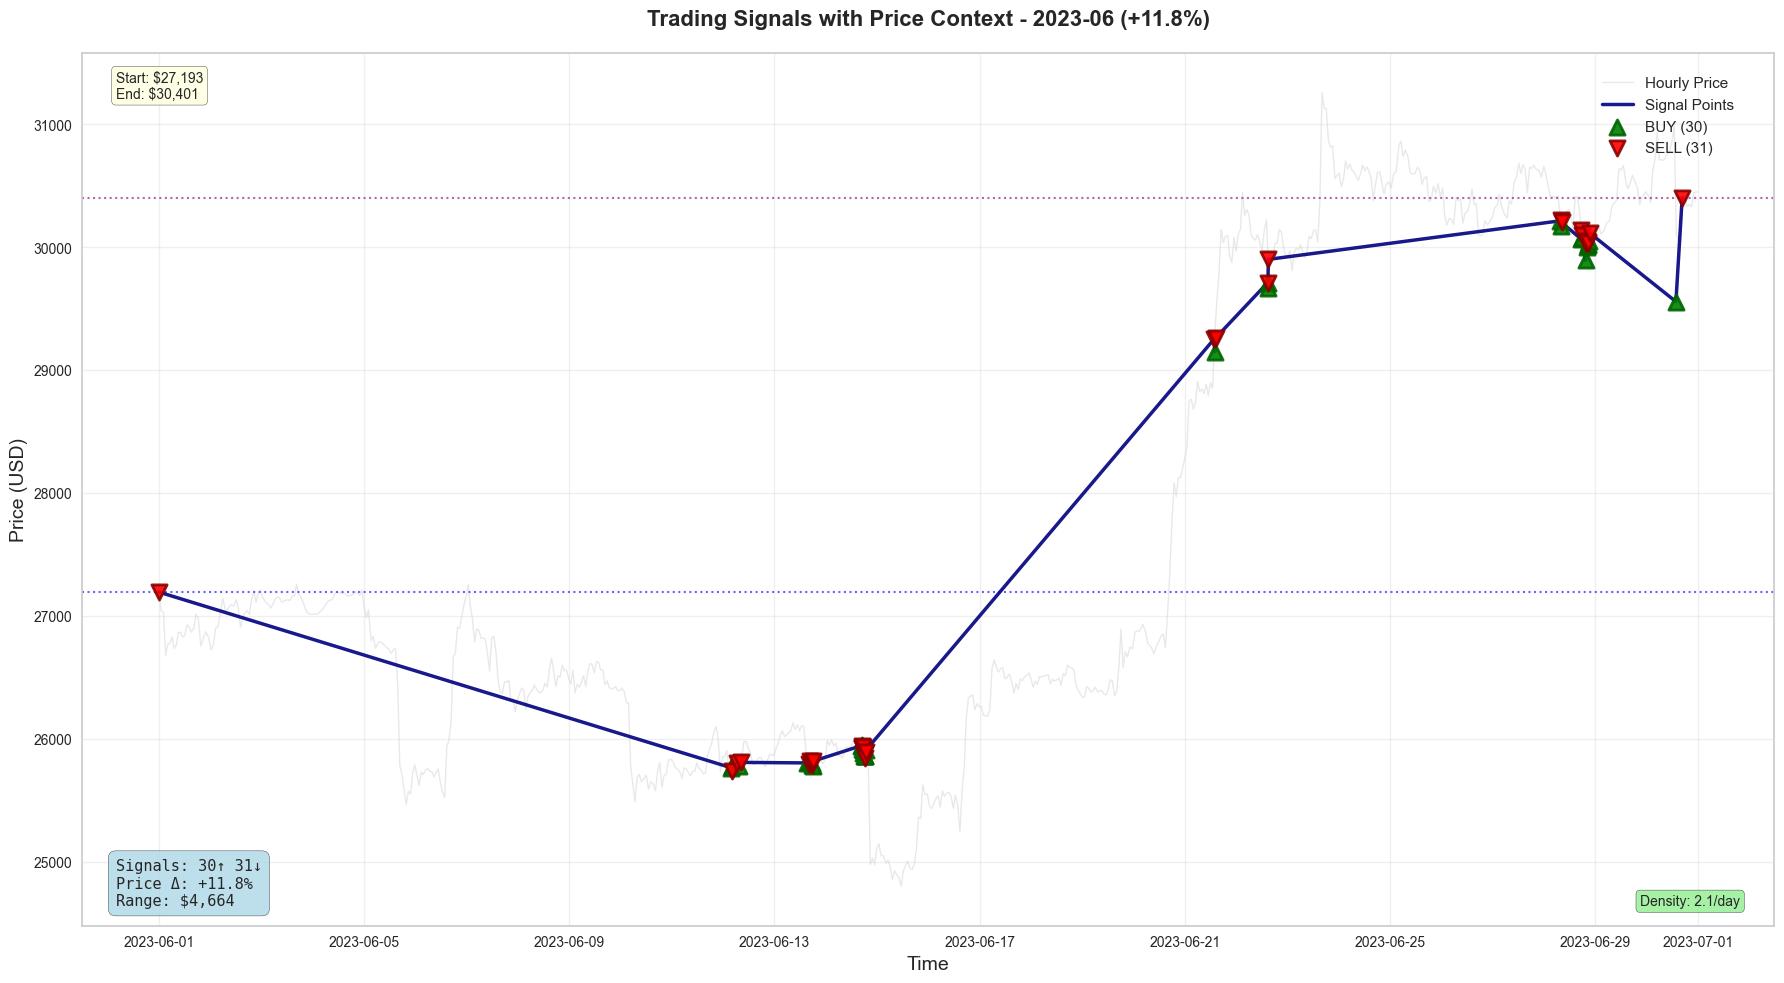


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-06-01 00:00   SELL $27193.20   1.00     Base
  2     2023-06-12 03:48    BUY $25764.00   0.80   -5.26%
  3     2023-06-12 04:06   SELL $25736.80   0.80   -0.11%
  4     2023-06-12 04:09    BUY $25777.20   1.00   +0.16%
  5     2023-06-12 06:26   SELL $25798.90   0.80   +0.08%
  6     2023-06-12 07:35    BUY $25782.10   0.80   -0.07%
  7     2023-06-12 08:16   SELL $25807.90   1.00   +0.10%
  8     2023-06-13 15:22    BUY $25803.60   0.80   -0.02%
  9     2023-06-13 16:18   SELL $25798.00   0.80   -0.02%
 10     2023-06-13 16:19    BUY $25809.50   1.00   +0.04%
 11     2023-06-13 16:43   SELL $25815.40   0.80   +0.02%
 12     2023-06-13 17:23    BUY $25800.80   1.00   -0.06%
 13     2023-06-13 17:34   SELL $25

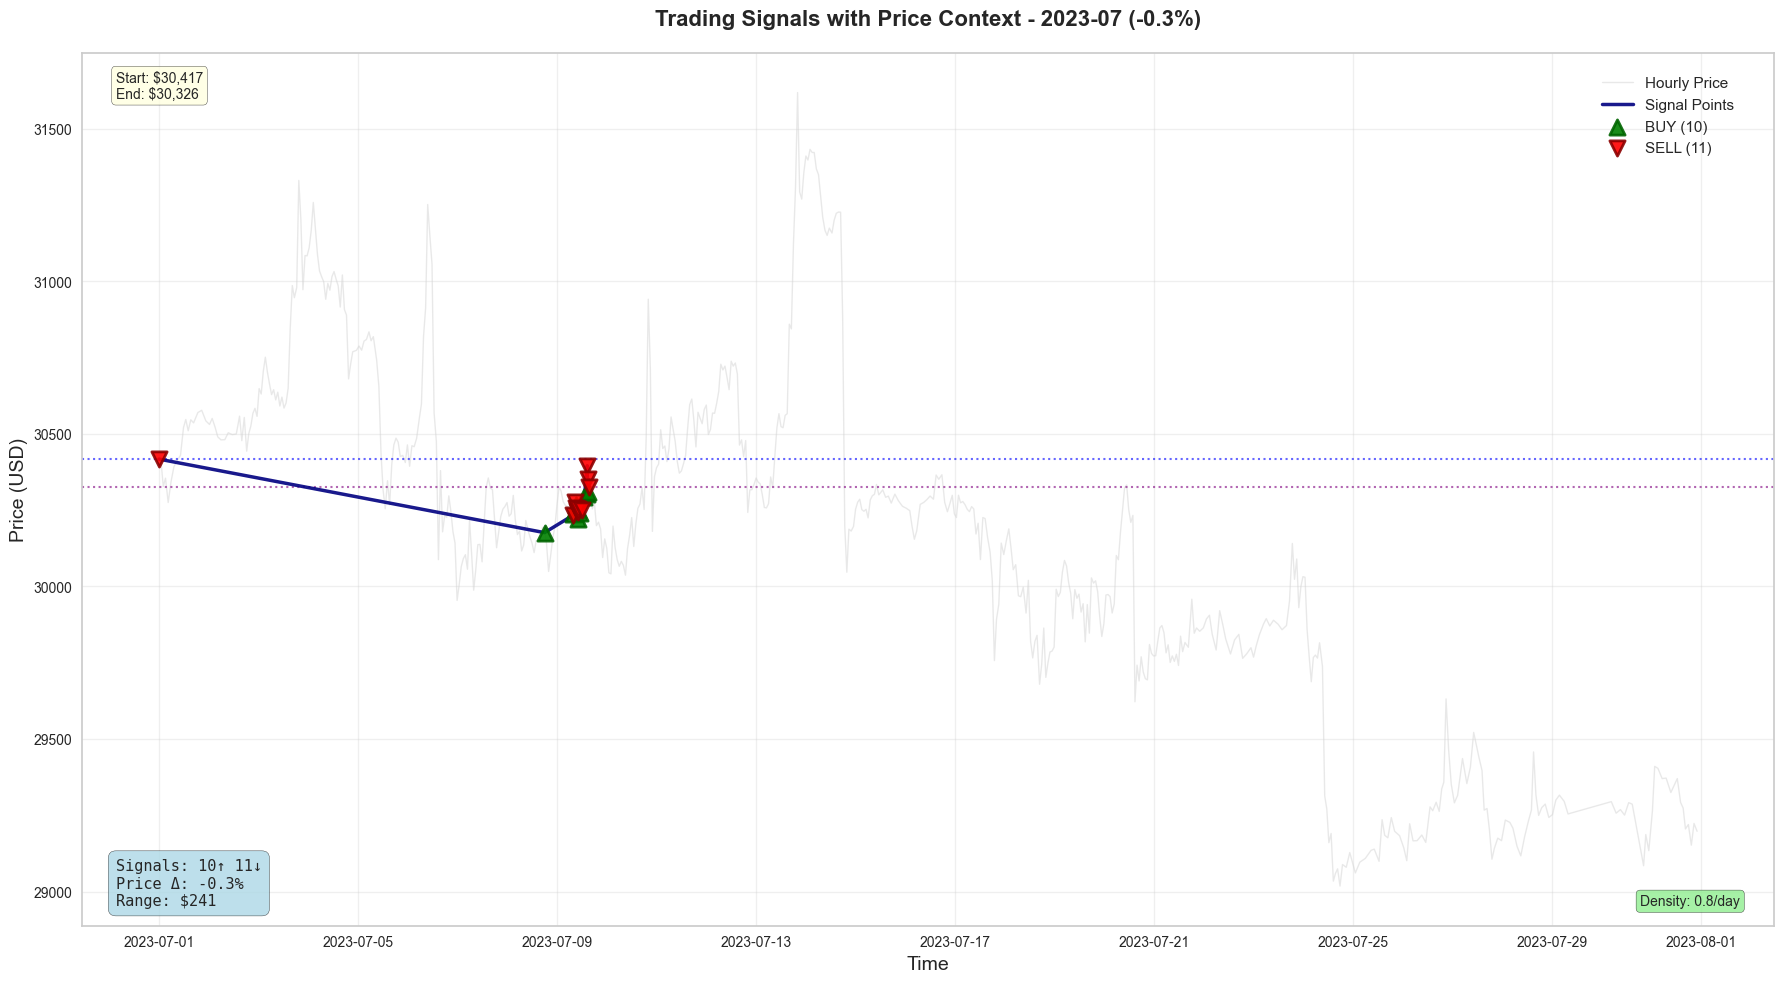


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-07-01 00:00   SELL $30416.90   1.00     Base
  2     2023-07-08 18:02    BUY $30176.00   1.00   -0.79%
  3     2023-07-09 07:37   SELL $30232.40   0.80   +0.19%
  4     2023-07-09 07:56    BUY $30237.70   0.80   +0.02%
  5     2023-07-09 08:56   SELL $30276.20   1.00   +0.13%
  6     2023-07-09 09:07    BUY $30266.40   0.80   -0.03%
  7     2023-07-09 09:13   SELL $30255.50   0.80   -0.04%
  8     2023-07-09 09:14    BUY $30252.20   0.80   -0.01%
  9     2023-07-09 09:49   SELL $30248.50   0.80   -0.01%
 10     2023-07-09 09:56    BUY $30249.80   0.80   +0.00%
 11     2023-07-09 09:57   SELL $30244.20   0.80   -0.02%
 12     2023-07-09 10:01    BUY $30220.40   1.00   -0.08%
 13     2023-07-09 10:02   SELL $30

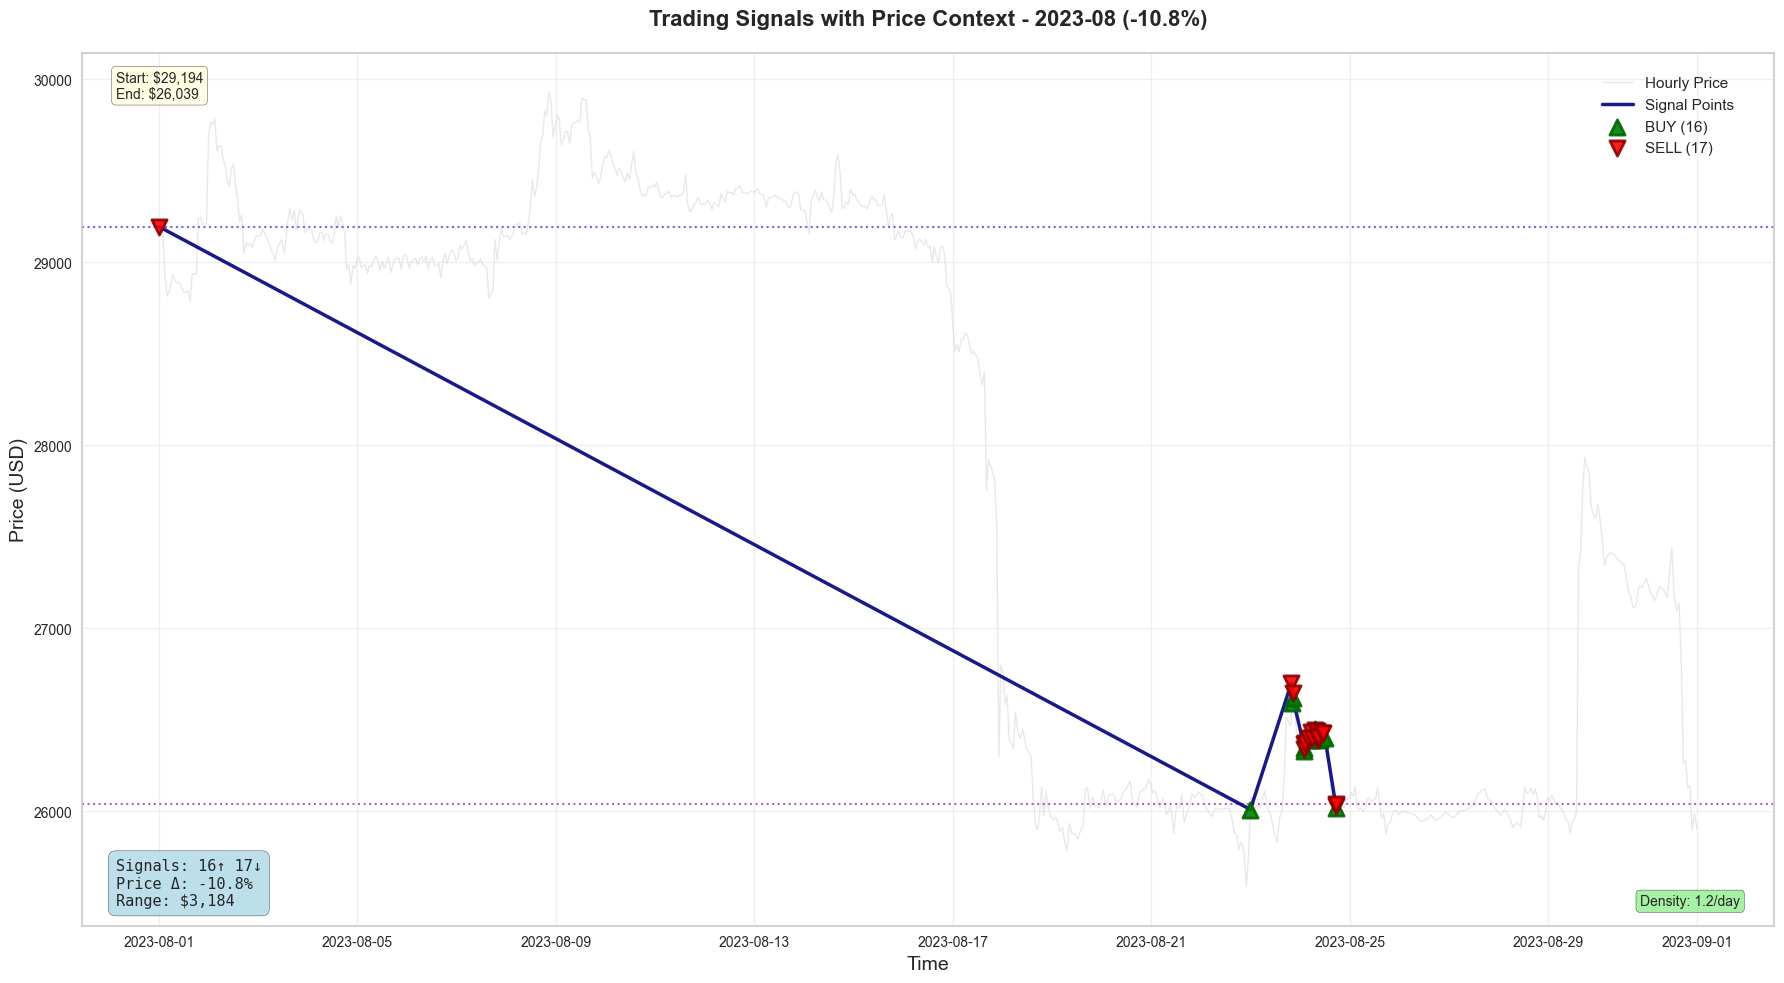


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-08-01 00:00   SELL $29194.30   1.00     Base
  2     2023-08-22 23:54    BUY $26010.80   0.80  -10.90%
  3     2023-08-23 19:41   SELL $26700.50   1.00   +2.65%
  4     2023-08-23 19:59    BUY $26590.70   0.80   -0.41%
  5     2023-08-23 20:24   SELL $26646.30   1.00   +0.21%
  6     2023-08-23 20:29    BUY $26617.20   1.00   -0.11%
  7     2023-08-24 01:36   SELL $26369.40   0.80   -0.93%
  8     2023-08-24 01:41    BUY $26349.20   0.80   -0.08%
  9     2023-08-24 01:43   SELL $26341.90   0.80   -0.03%
 10     2023-08-24 01:48    BUY $26329.10   0.80   -0.05%
 11     2023-08-24 02:32   SELL $26371.50   0.80   +0.16%
 12     2023-08-24 03:48    BUY $26389.80   0.80   +0.07%
 13     2023-08-24 03:49   SELL $26

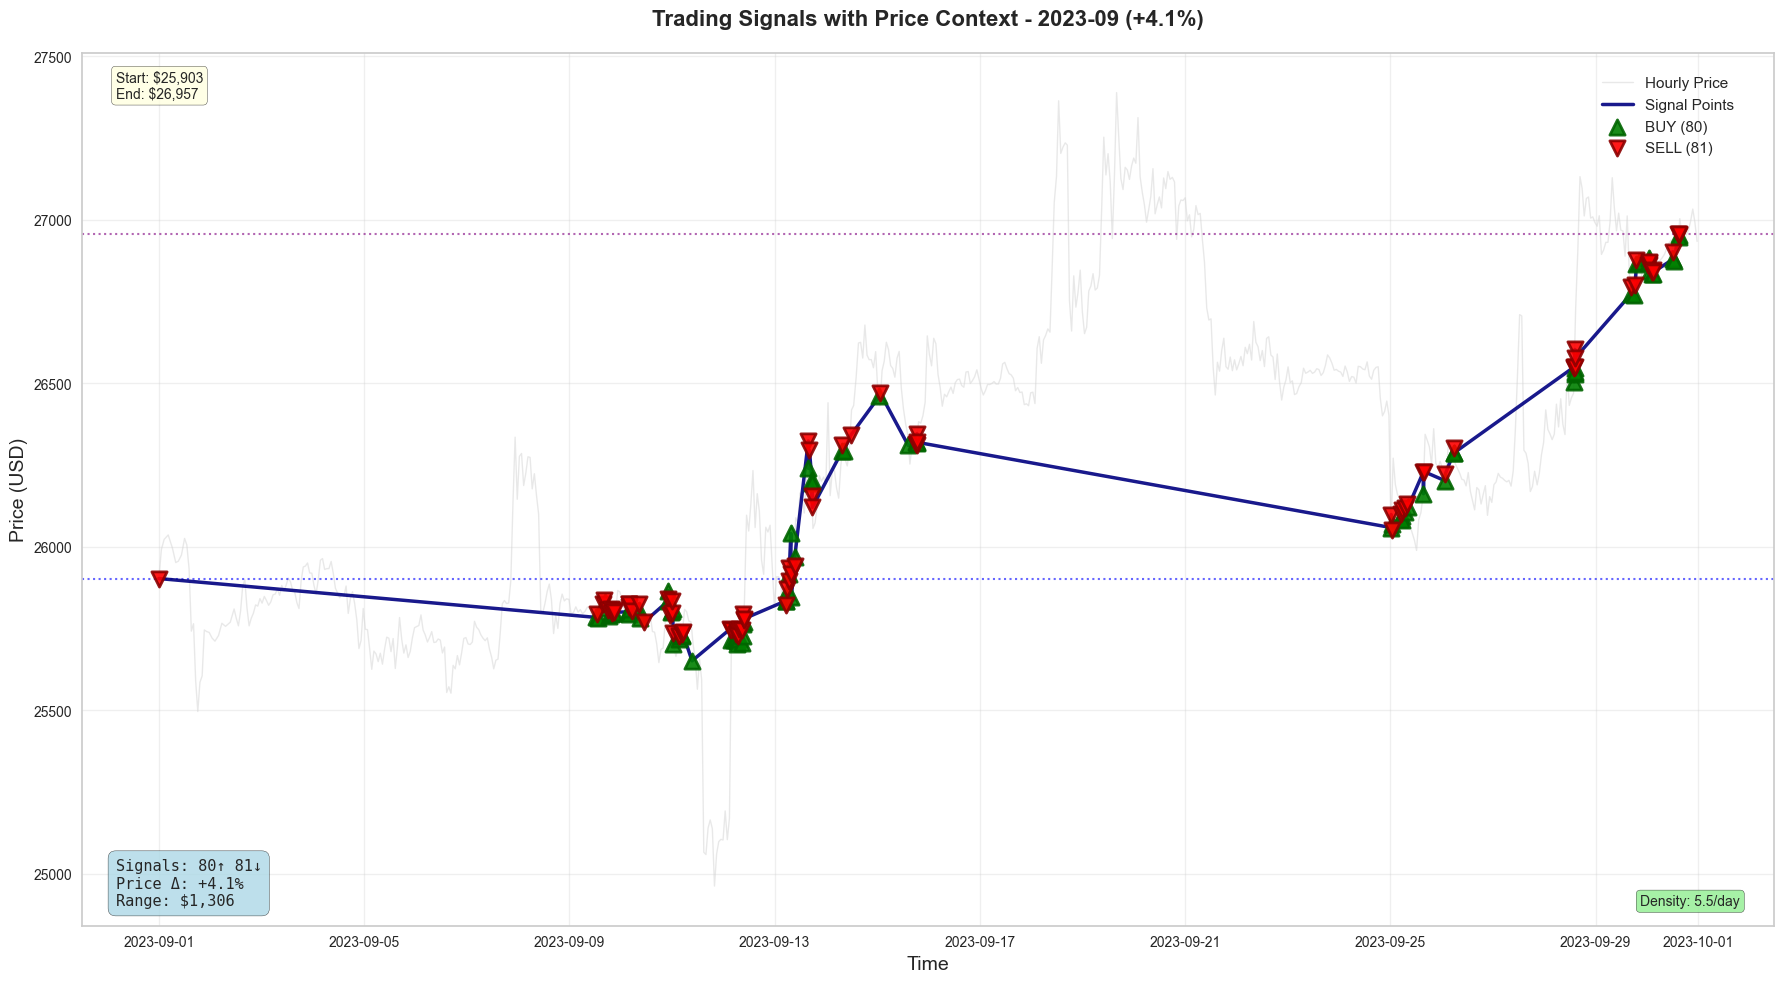


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-09-01 00:00   SELL $25902.70   1.00     Base
  2     2023-09-09 12:24    BUY $25783.90   0.80   -0.46%
  3     2023-09-09 13:08   SELL $25792.80   0.80   +0.03%
  4     2023-09-09 13:17    BUY $25782.80   0.80   -0.04%
  5     2023-09-09 15:39   SELL $25823.80   1.00   +0.16%
  6     2023-09-09 16:09    BUY $25811.50   0.80   -0.05%
  7     2023-09-09 16:12   SELL $25835.90   0.80   +0.09%
  8     2023-09-09 16:53    BUY $25831.80   0.80   -0.02%
  9     2023-09-09 18:03   SELL $25806.70   0.80   -0.10%
 10     2023-09-09 18:22    BUY $25789.20   1.00   -0.07%
 11     2023-09-09 19:33   SELL $25809.80   0.80   +0.08%
 12     2023-09-09 19:38    BUY $25794.60   0.80   -0.06%
 13     2023-09-09 20:08   SELL $25

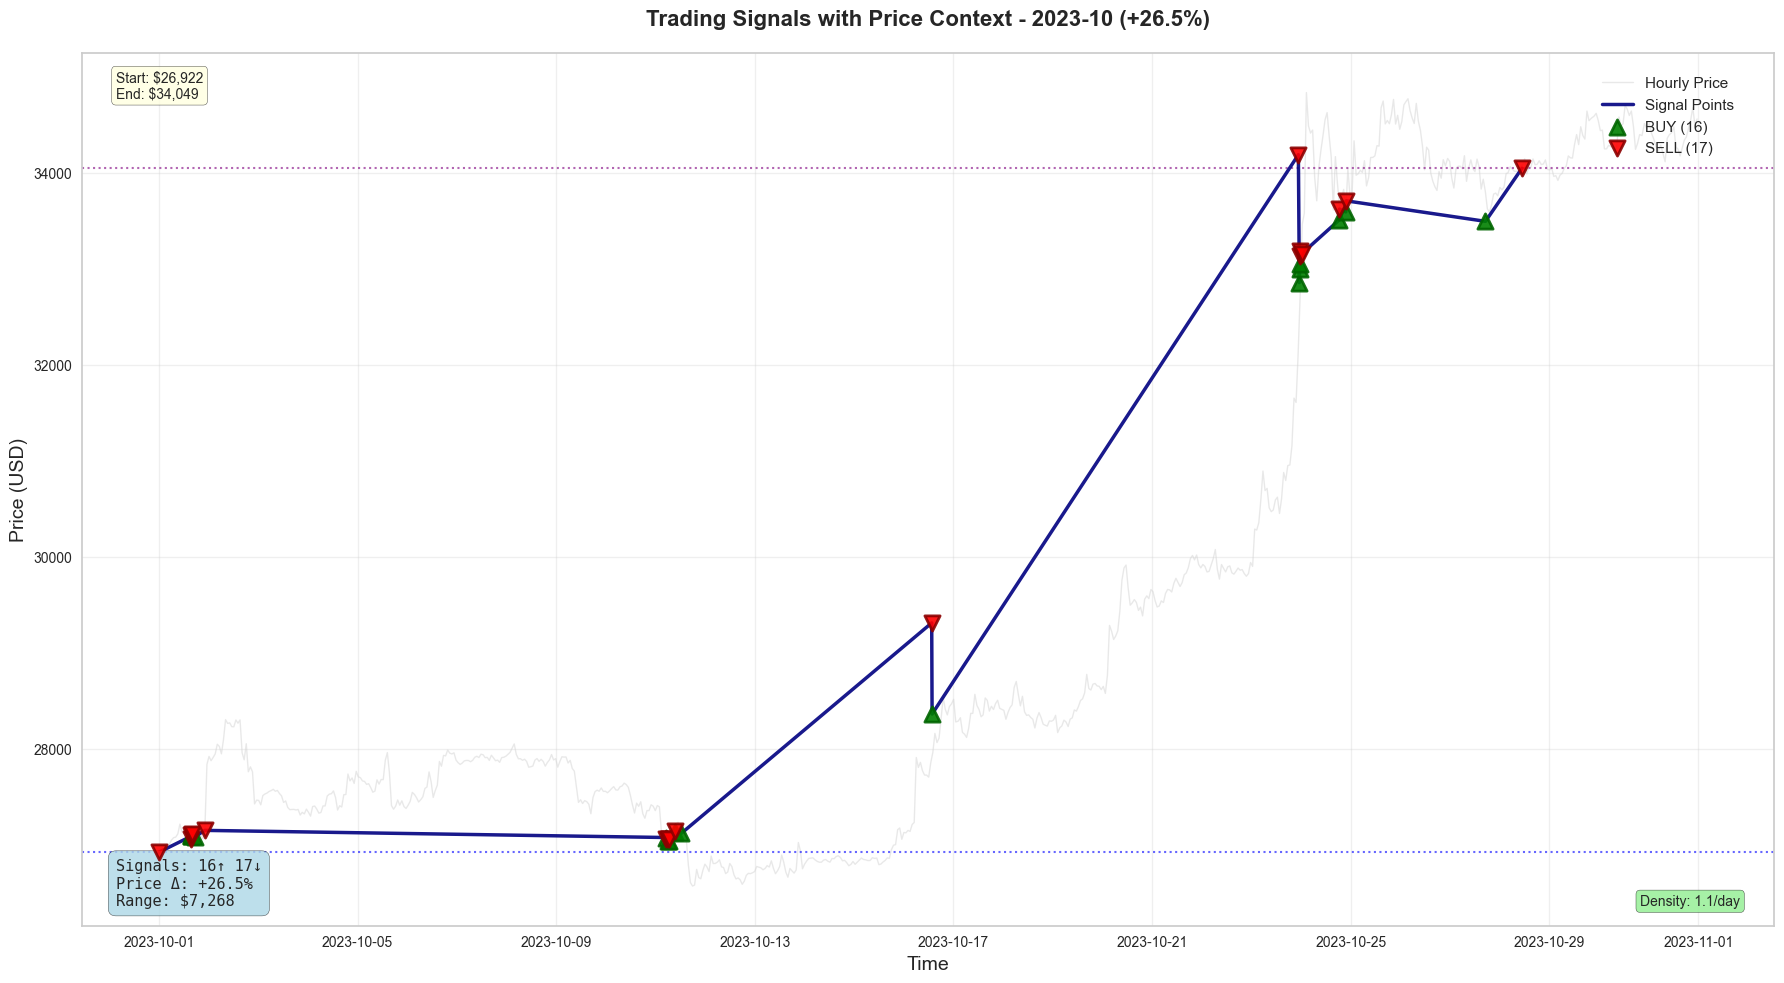


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-10-01 00:00   SELL $26921.90   1.00     Base
  2     2023-10-01 15:19    BUY $27085.70   0.80   +0.61%
  3     2023-10-01 15:20   SELL $27063.20   1.00   -0.08%
  4     2023-10-01 15:27    BUY $27093.80   1.00   +0.11%
  5     2023-10-01 15:39   SELL $27103.40   1.00   +0.04%
  6     2023-10-01 15:40    BUY $27097.10   0.80   -0.02%
  7     2023-10-01 15:52   SELL $27108.00   1.00   +0.04%
  8     2023-10-01 17:12    BUY $27080.40   0.80   -0.10%
  9     2023-10-01 22:09   SELL $27149.50   0.80   +0.26%
 10     2023-10-11 05:03    BUY $27075.10   0.80   -0.27%
 11     2023-10-11 05:04   SELL $27062.10   0.80   -0.05%
 12     2023-10-11 06:14    BUY $27043.20   0.80   -0.07%
 13     2023-10-11 06:16   SELL $27

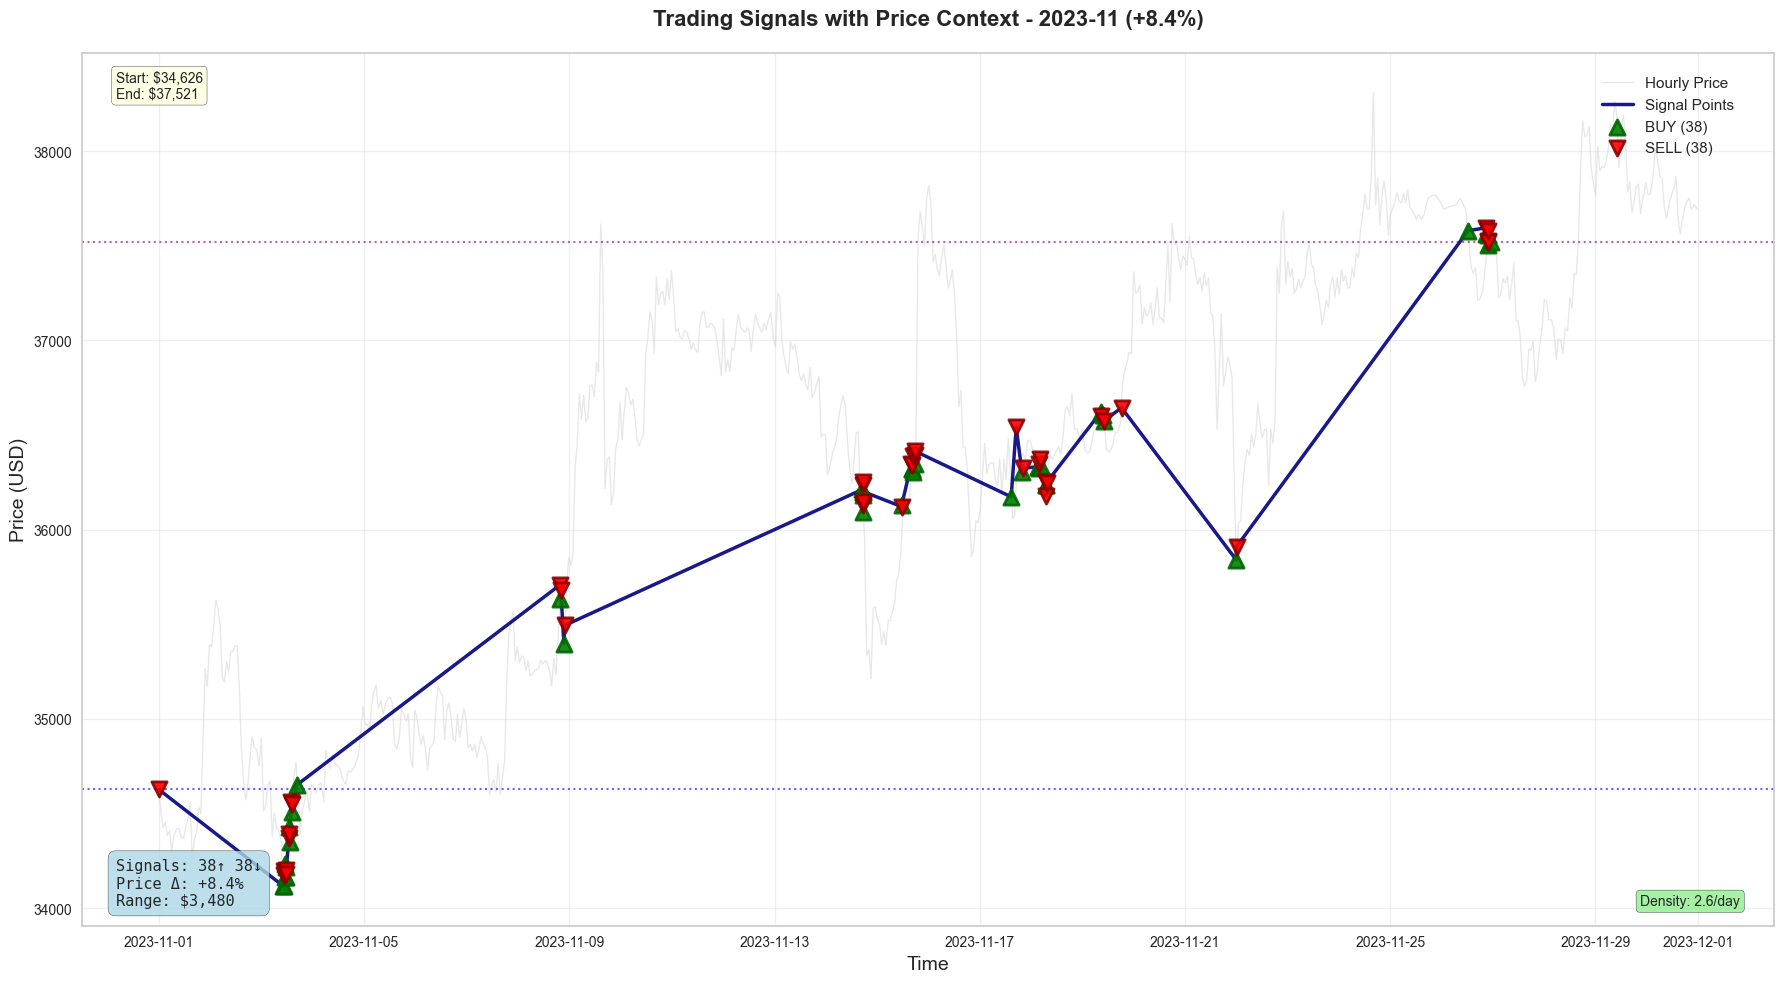


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-11-01 00:00   SELL $34626.50   1.00     Base
  2     2023-11-03 10:15    BUY $34116.10   0.80   -1.47%
  3     2023-11-03 10:21   SELL $34198.20   0.80   +0.24%
  4     2023-11-03 10:35    BUY $34116.10   0.80   -0.24%
  5     2023-11-03 10:41   SELL $34174.30   0.80   +0.17%
  6     2023-11-03 11:04    BUY $34233.80   0.80   +0.17%
  7     2023-11-03 11:07   SELL $34181.60   0.80   -0.15%
  8     2023-11-03 11:09    BUY $34165.60   1.00   -0.05%
  9     2023-11-03 11:16   SELL $34199.90   0.80   +0.10%
 10     2023-11-03 11:17    BUY $34218.80   0.80   +0.06%
 11     2023-11-03 11:19   SELL $34181.60   0.80   -0.11%
 12     2023-11-03 11:21    BUY $34166.40   1.00   -0.04%
 13     2023-11-03 12:49   SELL $34

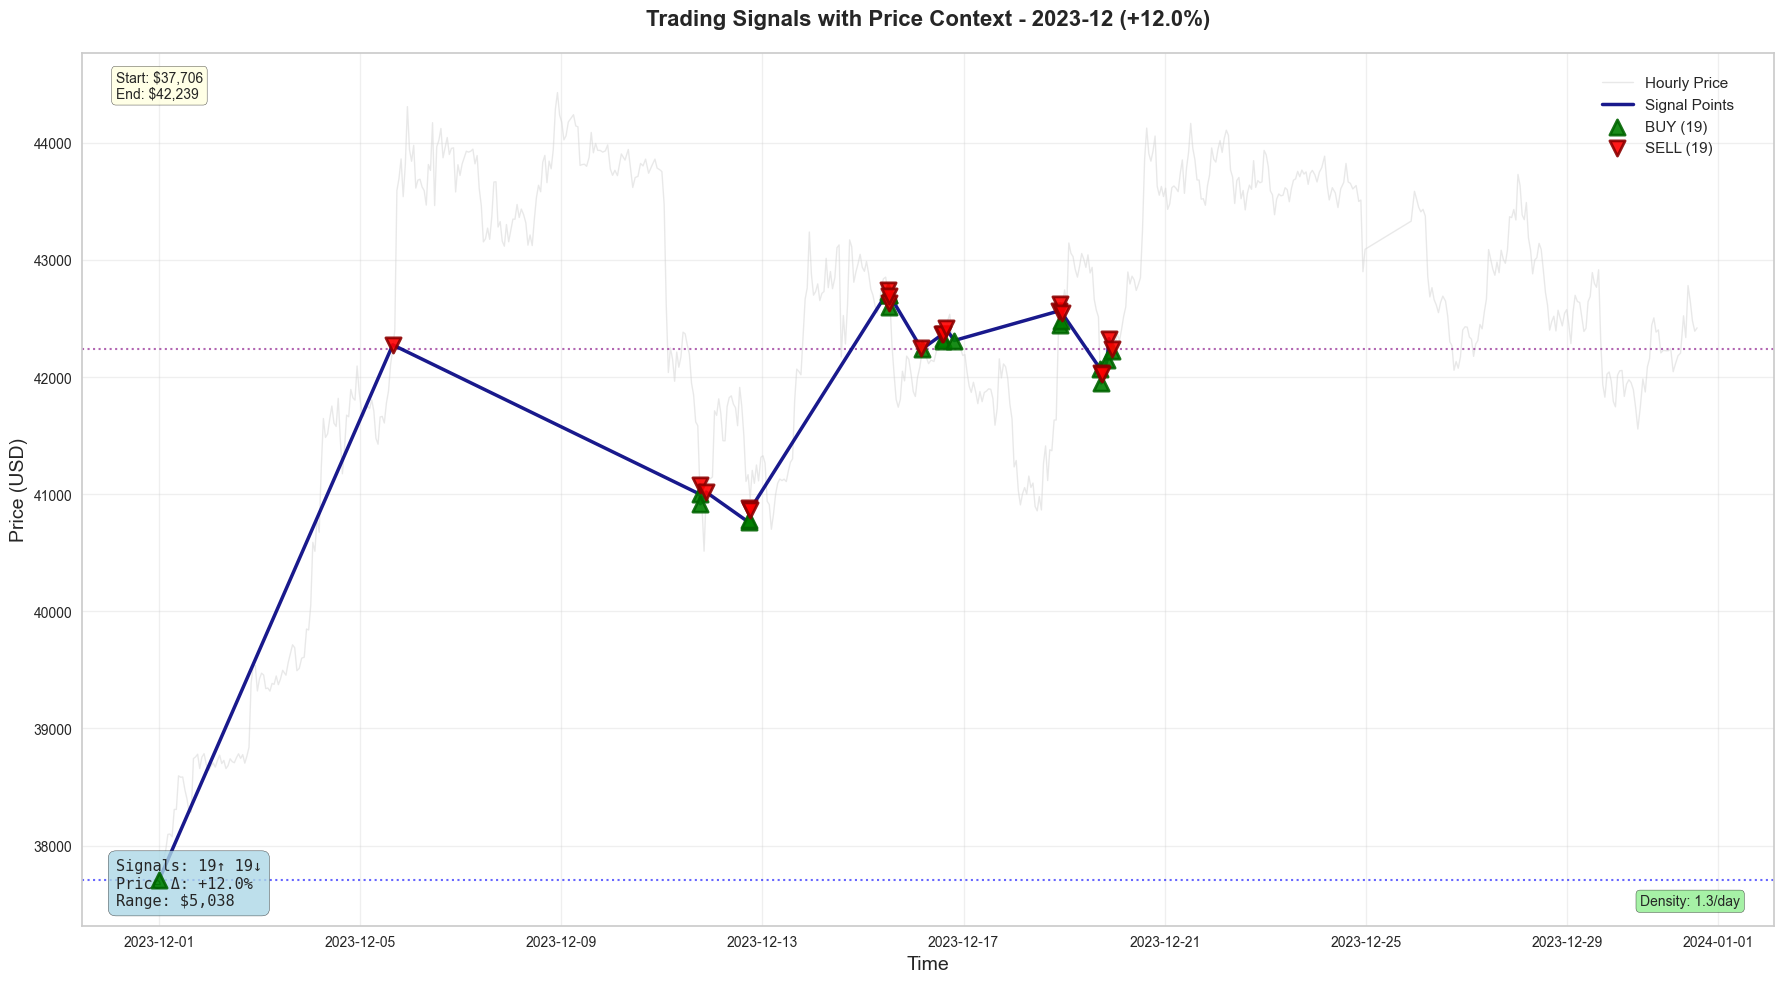


 DETAILED SIGNAL ANALYSIS:
------------------------------------------------------------------------------------------
  #            Timestamp Signal      Price   Conf Price Δ%
------------------------------------------------------------------------------------------
  1     2023-12-01 00:00    BUY $37705.50   1.00     Base
  2     2023-12-05 15:35   SELL $42275.40   1.00  +12.12%
  3     2023-12-11 18:11    BUY $41000.10   1.00   -3.02%
  4     2023-12-11 18:19   SELL $41079.40   0.80   +0.19%
  5     2023-12-11 18:21    BUY $40918.40   1.00   -0.39%
  6     2023-12-11 21:08   SELL $41018.40   1.00   +0.24%
  7     2023-12-12 17:34    BUY $40759.90   1.00   -0.63%
  8     2023-12-12 17:38   SELL $40880.40   1.00   +0.30%
  9     2023-12-12 17:46    BUY $40780.50   1.00   -0.24%
 10     2023-12-12 18:06   SELL $40867.30   0.80   +0.21%
 11     2023-12-15 11:54    BUY $42729.80   0.80   +4.56%
 12     2023-12-15 11:56   SELL $42743.40   0.80   +0.03%
 13     2023-12-15 12:15    BUY $42

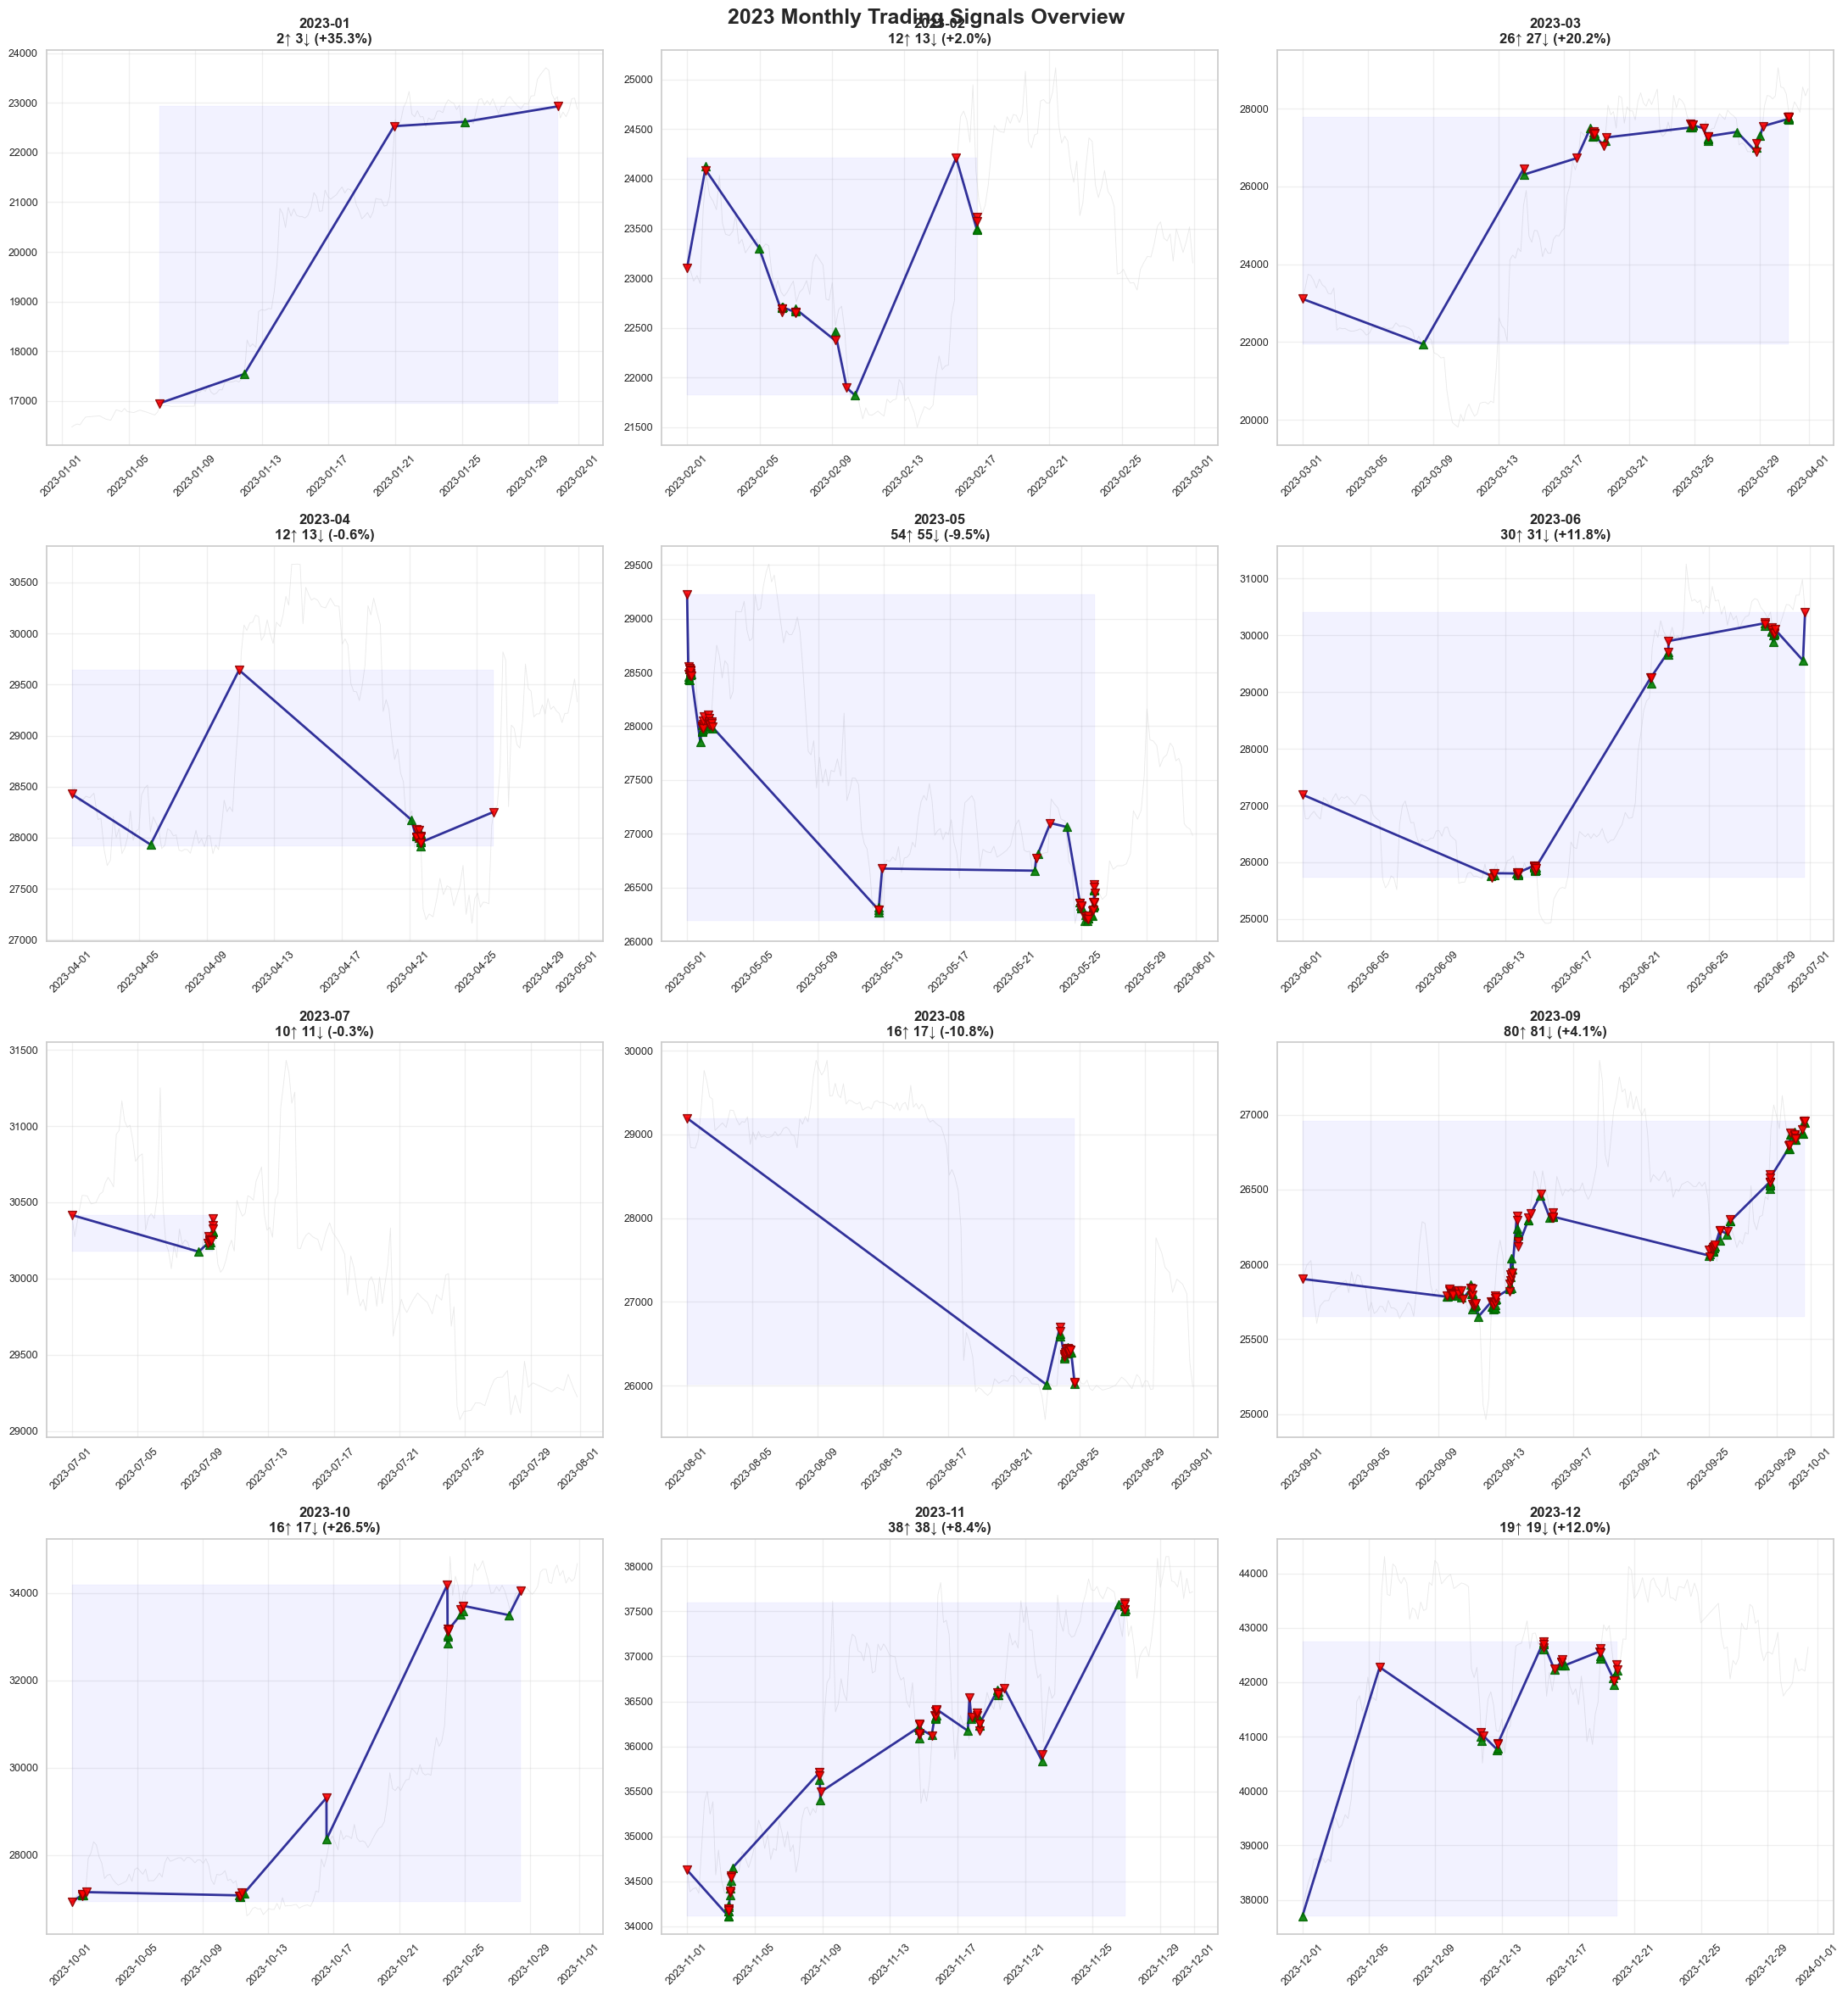

In [27]:
# Enhanced Alternative Month-by-Month Trading Signal Visualization with Clean Legend
print("\n" + "="*80)
print("MONTH-BY-MONTH TRADING SIGNAL VISUALIZATION (ENHANCED WITH PRICE DATA)")
print("="*80)

# Check if all_monthly_signals was created in cell 18
if 'all_monthly_signals' in locals() and all_monthly_signals:
    print(f" Visualizing {len(all_monthly_signals)} months of trading signals with price overlay...")
    
    # Create month-by-month visualizations with enhanced price data
    for month_key in sorted(all_monthly_signals.keys()):
        signals_df = all_monthly_signals[month_key]
        
        print(f"\n=== {month_key} ===")
        
        # Get signal statistics
        if not signals_df.empty and 'price' in signals_df.columns and 'signal' in signals_df.columns:
            # Check for valid price data
            valid_signals = signals_df.dropna(subset=['price', 'timestamp'])
            
            if len(valid_signals) == 0:
                print(f" No valid signals for {month_key}")
                continue
            
            # Load the complete month data for price overlay
            try:
                month_symbol = f"BTCUSD_1min_{month_key.replace('-', '_')}"
                complete_month_data = load_monthly_data(month_symbol)
                
                # Sample the complete data for visualization (every 60 minutes = 1 hour)
                complete_sample = complete_month_data.iloc[::60]  # Every hour
                
                print(f" Loaded {len(complete_month_data):,} complete price points, sampling {len(complete_sample):,} for visualization")
                
            except Exception as e:
                print(f"  Could not load complete price data: {e}")
                complete_sample = None
                
            total_signals = len(valid_signals)
            buy_signals = len(valid_signals[valid_signals['signal'] == 'BUY'])
            sell_signals = len(valid_signals[valid_signals['signal'] == 'SELL'])
            
            print(f"Period: {valid_signals['timestamp'].iloc[0]} to {valid_signals['timestamp'].iloc[-1]}")
            print(f"Total signals: {total_signals:,}")
            print(f"Buy signals: {buy_signals:,} ({buy_signals/total_signals*100:.1f}%)")
            print(f"Sell signals: {sell_signals:,} ({sell_signals/total_signals*100:.1f}%)")
            
            # Price statistics
            price_start = valid_signals['price'].iloc[0]
            price_end = valid_signals['price'].iloc[-1]
            price_min = valid_signals['price'].min()
            price_max = valid_signals['price'].max()
            price_change = (price_end - price_start) / price_start * 100
            
            print(f"Price range: ${price_min:,.2f} - ${price_max:,.2f}")
            print(f"Start price: ${price_start:,.2f}")
            print(f"End price: ${price_end:,.2f}")
            print(f"Price change: {price_change:+.2f}%")
            
            # Only create visualization if we have actual trading signals
            if buy_signals > 0 or sell_signals > 0:
                # Create enhanced visualization with CLEAN LEGEND
                plt.figure(figsize=(18, 10))
                
                # Plot complete price data as background if available
                if complete_sample is not None:
                    plt.plot(complete_sample.index, complete_sample['Close'], 
                            linewidth=1, alpha=0.5, color='lightgray', zorder=1,
                            label='Hourly Price')
                
                # Plot price line connecting signal points (more prominent)
                plt.plot(valid_signals['timestamp'], valid_signals['price'], 
                        linewidth=2.5, alpha=0.9, color='navy', zorder=2,
                        label='Signal Points')
                
                # Plot trading signals
                buy_points = valid_signals[valid_signals['signal'] == 'BUY']
                sell_points = valid_signals[valid_signals['signal'] == 'SELL']
                
                if len(buy_points) > 0:
                    plt.scatter(buy_points['timestamp'], buy_points['price'], 
                               marker='^', color='green', s=120, alpha=0.9, zorder=5,
                               edgecolors='darkgreen', linewidth=2,
                               label=f'BUY ({len(buy_points)})')
                
                if len(sell_points) > 0:
                    plt.scatter(sell_points['timestamp'], sell_points['price'], 
                               marker='v', color='red', s=120, alpha=0.9, zorder=5,
                               edgecolors='darkred', linewidth=2,
                               label=f'SELL ({len(sell_points)})')
                
                # Add ONLY essential reference lines (no labels to avoid clutter)
                plt.axhline(y=price_start, color='blue', linestyle=':', alpha=0.6, linewidth=1.5, zorder=1)
                plt.axhline(y=price_end, color='purple', linestyle=':', alpha=0.6, linewidth=1.5, zorder=1)
                
                # Enhanced formatting with CLEAN LEGEND
                plt.title(f'Trading Signals with Price Context - {month_key} ({price_change:+.1f}%)', 
                         fontsize=16, fontweight='bold', pad=20)
                plt.xlabel('Time', fontsize=14)
                plt.ylabel('Price (USD)', fontsize=14)
                
                # CLEAN LEGEND - only essential items, positioned to avoid overlap
                plt.legend(loc='upper right', framealpha=0.9, fontsize=11, 
                          bbox_to_anchor=(0.98, 0.98), borderaxespad=0)
                plt.grid(True, alpha=0.3)
                
                # Move text boxes to avoid legend overlap
                # Stats box - bottom left
                stats_text = f'Signals: {buy_signals}↑ {sell_signals}↓\nPrice Δ: {price_change:+.1f}%\nRange: ${price_max-price_min:,.0f}'
                plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
                        verticalalignment='bottom', fontsize=11, family='monospace')
                
                # Price reference info - top left
                ref_text = f'Start: ${price_start:,.0f}\nEnd: ${price_end:,.0f}'
                plt.text(0.02, 0.98, ref_text, transform=plt.gca().transAxes, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8),
                        verticalalignment='top', fontsize=10)
                
                # Signal density info - bottom right
                if complete_sample is not None:
                    hours_in_period = len(complete_month_data) / 60  # Convert minutes to hours
                    signal_density = total_signals / hours_in_period * 24  # Signals per day
                    density_text = f'Density: {signal_density:.1f}/day'
                    plt.text(0.98, 0.02, density_text, transform=plt.gca().transAxes, 
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8),
                            verticalalignment='bottom', horizontalalignment='right', fontsize=10)
                
                plt.tight_layout()
                plt.show()
                
                # Print enhanced signal timing analysis (unchanged)
                print(f"\n DETAILED SIGNAL ANALYSIS:")
                print("-" * 90)
                print(f"{'#':>3} {'Timestamp':>20} {'Signal':>6} {'Price':>10} {'Conf':>6} {'Price Δ%':>8}")
                print("-" * 90)
                
                for i in range(len(valid_signals)):
                    row = valid_signals.iloc[i]
                    conf_str = f"{row['confidence']:.2f}" if 'confidence' in row else "N/A"
                    
                    # Calculate price change from previous signal
                    if i > 0:
                        prev_price = valid_signals.iloc[i-1]['price']
                        price_delta = (row['price'] - prev_price) / prev_price * 100
                        price_delta_str = f"{price_delta:+.2f}%"
                    else:
                        price_delta_str = "Base"
                    
                    print(f"{i+1:>3} {row['timestamp'].strftime('%Y-%m-%d %H:%M'):>20} {row['signal']:>6} ${row['price']:>8.2f} {conf_str:>6} {price_delta_str:>8}")
                
                # Signal transition analysis (unchanged)
                if len(valid_signals) > 1:
                    transitions = []
                    for i in range(1, len(valid_signals)):
                        prev_signal = valid_signals.iloc[i-1]['signal']
                        curr_signal = valid_signals.iloc[i]['signal']
                        if prev_signal != curr_signal:
                            transitions.append(f"{prev_signal}→{curr_signal}")
                    
                    print(f"\n SIGNAL TRANSITIONS:")
                    transition_counts = {}
                    for t in transitions:
                        transition_counts[t] = transition_counts.get(t, 0) + 1
                    
                    for transition, count in transition_counts.items():
                        print(f"  {transition}: {count} times")
                
            else:
                print(f"  No buy/sell signals for {month_key}")
        else:
            print(f" No valid signals for {month_key} - missing required columns")
        
        print("-" * 80)

    # CLEANED UP summary visualization
    print(f"\n=== ENHANCED YEAR-OVERVIEW COMPARISON ===")
    
    # Filter months that have actual trading signals
    months_with_signals = {}
    for month_key, signals_df in all_monthly_signals.items():
        if not signals_df.empty and 'price' in signals_df.columns:
            valid_signals = signals_df.dropna(subset=['price', 'timestamp'])
            buy_count = len(valid_signals[valid_signals['signal'] == 'BUY'])
            sell_count = len(valid_signals[valid_signals['signal'] == 'SELL'])
            if buy_count > 0 or sell_count > 0:
                months_with_signals[month_key] = valid_signals
    
    if len(months_with_signals) >= 3:
        # Create CLEAN subplots for comparison
        n_months = len(months_with_signals)
        n_cols = 3
        n_rows = (n_months + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 6 * n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = [ax for row in axes for ax in (row if isinstance(row, np.ndarray) else [row])]
        
        for idx, (month_key, signals_df) in enumerate(sorted(months_with_signals.items())):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            
            # Try to load complete price data for this month (lighter background)
            try:
                month_symbol = f"BTCUSD_1min_{month_key.replace('-', '_')}"
                complete_data = load_monthly_data(month_symbol)
                # Sample every 4 hours for overview
                price_sample = complete_data.iloc[::240]
                ax.plot(price_sample.index, price_sample['Close'], 
                       linewidth=0.6, color='lightgray', alpha=0.5, zorder=1)
            except:
                pass  # Skip if can't load complete data
            
            # Plot signal price line (more prominent)
            ax.plot(signals_df['timestamp'], signals_df['price'], 
                   linewidth=2, color='navy', alpha=0.8, zorder=2)
            
            # Plot signals with clean styling
            buy_points = signals_df[signals_df['signal'] == 'BUY']
            sell_points = signals_df[signals_df['signal'] == 'SELL']
            
            if len(buy_points) > 0:
                ax.scatter(buy_points['timestamp'], buy_points['price'], 
                          marker='^', color='green', s=50, alpha=0.9, zorder=5,
                          edgecolors='darkgreen', linewidth=1)
            if len(sell_points) > 0:
                ax.scatter(sell_points['timestamp'], sell_points['price'], 
                          marker='v', color='red', s=50, alpha=0.9, zorder=5,
                          edgecolors='darkred', linewidth=1)
            
            # Clean subplot formatting
            buy_count = len(buy_points)
            sell_count = len(sell_points)
            price_change = (signals_df['price'].iloc[-1] - signals_df['price'].iloc[0]) / signals_df['price'].iloc[0] * 100
            
            ax.set_title(f'{month_key}\n{buy_count}↑ {sell_count}↓ ({price_change:+.1f}%)', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45, labelsize=9)
            ax.tick_params(axis='y', labelsize=9)
            
            # Subtle price range indication
            ax.fill_between(signals_df['timestamp'], 
                           signals_df['price'].min(), signals_df['price'].max(), 
                           alpha=0.05, color='blue')
        
        # Hide unused subplots
        for idx in range(len(months_with_signals), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('2023 Monthly Trading Signals Overview', 
                    fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()
    elif len(months_with_signals) > 0:
        print(f"Only {len(months_with_signals)} months have trading signals. Need at least 3 for overview comparison.")
        print(f"Months with signals: {list(months_with_signals.keys())}")
    else:
        print("No months have trading signals for overview.")

else:
    print("No monthly signals available for visualization. Please run cell 18 (clustering analysis) first.")
    print("Cell 18 creates the 'all_monthly_signals' variable needed for this visualization.")

In [23]:
# Examine the all_monthly_signals dataset
print("="*80)
print("EXAMINING ALL_MONTHLY_SIGNALS DATASET")
print("="*80)

if 'all_monthly_signals' in locals() and all_monthly_signals:
    print(f" Dataset contains {len(all_monthly_signals)} months of data\n")
    
    # Overview of all months
    print("MONTH-BY-MONTH OVERVIEW:")
    print("-" * 50)
    for month_key in sorted(all_monthly_signals.keys()):
        signals_df = all_monthly_signals[month_key]
        if not signals_df.empty:
            buy_count = len(signals_df[signals_df['signal'] == 'BUY'])
            sell_count = len(signals_df[signals_df['signal'] == 'SELL'])
            total = len(signals_df)
            price_range = f"${signals_df['price'].min():.0f}-${signals_df['price'].max():.0f}"
            print(f"{month_key:15} | Total: {total:3d} | Buy: {buy_count:2d} | Sell: {sell_count:2d} | Price: {price_range}")
        else:
            print(f"{month_key:15} | No data")
    
    # Detailed view of a sample month
    sample_month = list(all_monthly_signals.keys())[0]
    sample_data = all_monthly_signals[sample_month]
    
    print(f"\n DETAILED VIEW OF SAMPLE MONTH: {sample_month}")
    print("-" * 60)
    print(f"Data shape: {sample_data.shape}")
    print(f"Columns: {list(sample_data.columns)}")
    print(f"Data types:\n{sample_data.dtypes}")
    
    if not sample_data.empty:
        print(f"\n FIRST 10 SIGNALS FROM {sample_month}:")
        print(sample_data.head(10).to_string())
        
        if len(sample_data) > 10:
            print(f"\n LAST 5 SIGNALS FROM {sample_month}:")
            print(sample_data.tail(5).to_string())
    
    # Statistics across all months
    print(f"\n AGGREGATE STATISTICS:")
    print("-" * 40)
    total_signals = sum(len(df) for df in all_monthly_signals.values() if not df.empty)
    total_buy = sum(len(df[df['signal'] == 'BUY']) for df in all_monthly_signals.values() if not df.empty)
    total_sell = sum(len(df[df['signal'] == 'SELL']) for df in all_monthly_signals.values() if not df.empty)
    
    print(f"Total signals across all months: {total_signals:,}")
    print(f"Total BUY signals: {total_buy:,} ({total_buy/total_signals*100:.1f}%)")
    print(f"Total SELL signals: {total_sell:,} ({total_sell/total_signals*100:.1f}%)")
    
    # Price statistics
    all_prices = []
    for df in all_monthly_signals.values():
        if not df.empty and 'price' in df.columns:
            all_prices.extend(df['price'].dropna().tolist())
    
    if all_prices:
        import numpy as np
        print(f"\nPrice statistics across all signals:")
        print(f"  Min price: ${min(all_prices):,.2f}")
        print(f"  Max price: ${max(all_prices):,.2f}")
        print(f"  Mean price: ${np.mean(all_prices):,.2f}")
        print(f"  Median price: ${np.median(all_prices):,.2f}")
    
    # Let user choose which month to examine in detail
    print(f"\n CHOOSE A MONTH TO EXAMINE IN DETAIL:")
    print("Available months:", sorted(all_monthly_signals.keys()))
    
else:
    print(" all_monthly_signals dataset not found.")
    print("Please run cell 18 (Monthly Trading Signal Pattern Analysis) first.")

print("="*80)

EXAMINING ALL_MONTHLY_SIGNALS DATASET
 Dataset contains 12 months of data

MONTH-BY-MONTH OVERVIEW:
--------------------------------------------------
2023-01         | Total:   5 | Buy:  2 | Sell:  3 | Price: $16953-$22930
2023-02         | Total:  25 | Buy: 12 | Sell: 13 | Price: $21819-$24211
2023-03         | Total:  53 | Buy: 26 | Sell: 27 | Price: $21946-$27788
2023-04         | Total:  25 | Buy: 12 | Sell: 13 | Price: $27917-$29642
2023-05         | Total: 109 | Buy: 54 | Sell: 55 | Price: $26191-$29227
2023-06         | Total:  61 | Buy: 30 | Sell: 31 | Price: $25737-$30401
2023-07         | Total:  21 | Buy: 10 | Sell: 11 | Price: $30176-$30417
2023-08         | Total:  33 | Buy: 16 | Sell: 17 | Price: $26011-$29194
2023-09         | Total: 161 | Buy: 80 | Sell: 81 | Price: $25651-$26957
2023-10         | Total:  33 | Buy: 16 | Sell: 17 | Price: $26922-$34190
2023-11         | Total:  76 | Buy: 38 | Sell: 38 | Price: $34116-$37596
2023-12         | Total:  38 | Buy: 19 | Sell:

In [ ]:
# Generate COMPLETE prediction dataset for all minutes
# This shows what the KNN model ACTUALLY predicts vs the filtered signals
print("="*80)
print("COMPLETE KNN MODEL PREDICTIONS (ALL MINUTES)")
print("="*80)

# Choose a month to demonstrate the complete predictions
DEMO_MONTH = '2023-01'  # Change this to examine different months
print(f" Generating COMPLETE predictions for {DEMO_MONTH}...")

try:
    # Load the month data
    month_symbol = f"BTCUSD_1min_{DEMO_MONTH.replace('-', '_')}"
    month_data = load_monthly_data(month_symbol)
    
    # Generate ALL predictions (no filtering!)
    month_predictions = generate_predictions(knn_model, month_data, feature_columns, model_type=model_type)
    
    print(f"\n COMPLETE PREDICTION RESULTS:")
    print(f"Total records: {len(month_predictions):,}")
    print(f"Date range: {month_predictions.index[0]} to {month_predictions.index[-1]}")
    
    # Show prediction distribution
    pred_counts = month_predictions['prediction_label'].value_counts()
    print(f"\nPrediction distribution:")
    print(f"  0 (Down/Sell): {pred_counts[0]:,} ({pred_counts[0]/len(month_predictions)*100:.1f}%)")
    print(f"  1 (Up/Buy): {pred_counts[1]:,} ({pred_counts[1]/len(month_predictions)*100:.1f}%)")
    
    # Show confidence distribution
    if 'prediction_score' in month_predictions.columns:
        conf_stats = month_predictions['prediction_score'].describe()
        print(f"\nConfidence statistics:")
        print(f"  Mean: {conf_stats['mean']:.3f}")
        print(f"  Min: {conf_stats['min']:.3f}")
        print(f"  Max: {conf_stats['max']:.3f}")
        
        # Count high-confidence predictions
        high_conf = len(month_predictions[month_predictions['prediction_score'] >= 0.7])
        print(f"  High confidence (≥0.7): {high_conf:,} ({high_conf/len(month_predictions)*100:.1f}%)")
    
    # Compare with filtered signals
    if DEMO_MONTH in all_monthly_signals:
        filtered_signals = len(all_monthly_signals[DEMO_MONTH])
        print(f"\n COMPARISON:")
        print(f"Complete predictions: {len(month_predictions):,}")
        print(f"Filtered signals: {filtered_signals}")
        print(f"Data reduction: {(1 - filtered_signals/len(month_predictions))*100:.1f}%")
    
    # Show first 20 predictions with details
    print(f"\n FIRST 20 COMPLETE PREDICTIONS:")
    print("-" * 100)
    print(f"{'#':>3} {'Timestamp':>20} {'Pred':>4} {'Conf':>6} {'Price':>10} {'Actual':>6}")
    print("-" * 100)
    
    for i in range(min(20, len(month_predictions))):
        row = month_predictions.iloc[i]
        timestamp = row.name.strftime('%Y-%m-%d %H:%M:%S')
        pred = row['prediction_label']
        conf = f"{row.get('prediction_score', 0):.3f}"
        price = f"${row['Close']:,.2f}"
        actual = row.get('future_trend', 'N/A')
        print(f"{i+1:>3} {timestamp:>20} {pred:>4} {conf:>6} {price:>10} {actual:>6}")
    
    print(f"\n... and {len(month_predictions) - 20:,} more predictions")
    
    # Show predictions around signal changes
    if DEMO_MONTH in all_monthly_signals:
        signals_df = all_monthly_signals[DEMO_MONTH]
        if not signals_df.empty:
            print(f"\n PREDICTIONS AROUND FIRST SIGNAL CHANGE:")
            first_signal_time = signals_df['timestamp'].iloc[0]
            
            # Find the signal in complete predictions
            signal_idx = month_predictions.index.get_indexer([first_signal_time], method='nearest')[0]
            
            # Show 10 predictions before and after the signal
            start_idx = max(0, signal_idx - 5)
            end_idx = min(len(month_predictions), signal_idx + 6)
            
            print("-" * 100)
            print(f"{'#':>3} {'Timestamp':>20} {'Pred':>4} {'Conf':>6} {'Price':>10} {'Signal?':>8}")
            print("-" * 100)
            
            for i in range(start_idx, end_idx):
                row = month_predictions.iloc[i]
                timestamp = row.name.strftime('%Y-%m-%d %H:%M:%S')
                pred = row['prediction_label']
                conf = f"{row.get('prediction_score', 0):.3f}"
                price = f"${row['Close']:,.2f}"
                
                # Check if this timestamp matches a signal
                is_signal = any(abs((s - row.name).total_seconds()) < 60 for s in signals_df['timestamp'])
                signal_mark = " YES" if is_signal else ""
                
                print(f"{i+1:>3} {timestamp:>20} {pred:>4} {conf:>6} {price:>10} {signal_mark:>8}")
    
    # Create a proper complete signals dataset
    complete_signals = month_predictions.copy()
    complete_signals['signal'] = complete_signals['prediction_label'].map({0: 'SELL', 1: 'BUY'})
    complete_signals['confidence'] = complete_signals.get('prediction_score', 0.5)
    
    # Store for comparison
    globals()[f'complete_predictions_{DEMO_MONTH.replace("-", "_")}'] = complete_signals
    
    print(f"\n STORED COMPLETE DATASET:")
    print(f"Variable: complete_predictions_{DEMO_MONTH.replace('-', '_')}")
    print(f"Contains: {len(complete_signals):,} predictions with full timestamps")
    
except Exception as e:
    print(f" Error generating complete predictions: {e}")

print("="*80)

COMPLETE KNN MODEL PREDICTIONS (ALL MINUTES)
 Generating COMPLETE predictions for 2023-01...
Loading data for: BTCUSD_1min_2023_01
Loaded from ArcticDB - Data shape: (38013, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
Generating predictions using pycaret model...
Feature data shape: (38013, 20)
PyCaret prediction completed successfully

 COMPLETE PREDICTION RESULTS:
Total records: 38,013
Date range: 2023-01-01 14:00:00 to 2023-01-31 23:59:00

Prediction distribution:
  0 (Down/Sell): 12,653 (33.3%)
  1 (Up/Buy): 25,360 (66.7%)

Confidence statistics:
  Mean: 0.930
  Min: 0.600
  Max: 1.000
  High confidence (≥0.7): 32,174 (84.6%)

 COMPARISON:
Complete predictions: 38,013
Filtered signals: 5
Data 

COMPLETE PREDICTIONS vs FILTERED SIGNALS VISUALIZATION
 Generating complete predictions for all months...
  Processing 2023-01...
Loading data for: BTCUSD_1min_2023_01
Loaded from ArcticDB - Data shape: (38013, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
Generating predictions using pycaret model...
Feature data shape: (38013, 20)
PyCaret prediction completed successfully
  Processing 2023-02...
Loading data for: BTCUSD_1min_2023_02
Loaded from ArcticDB - Data shape: (38508, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_

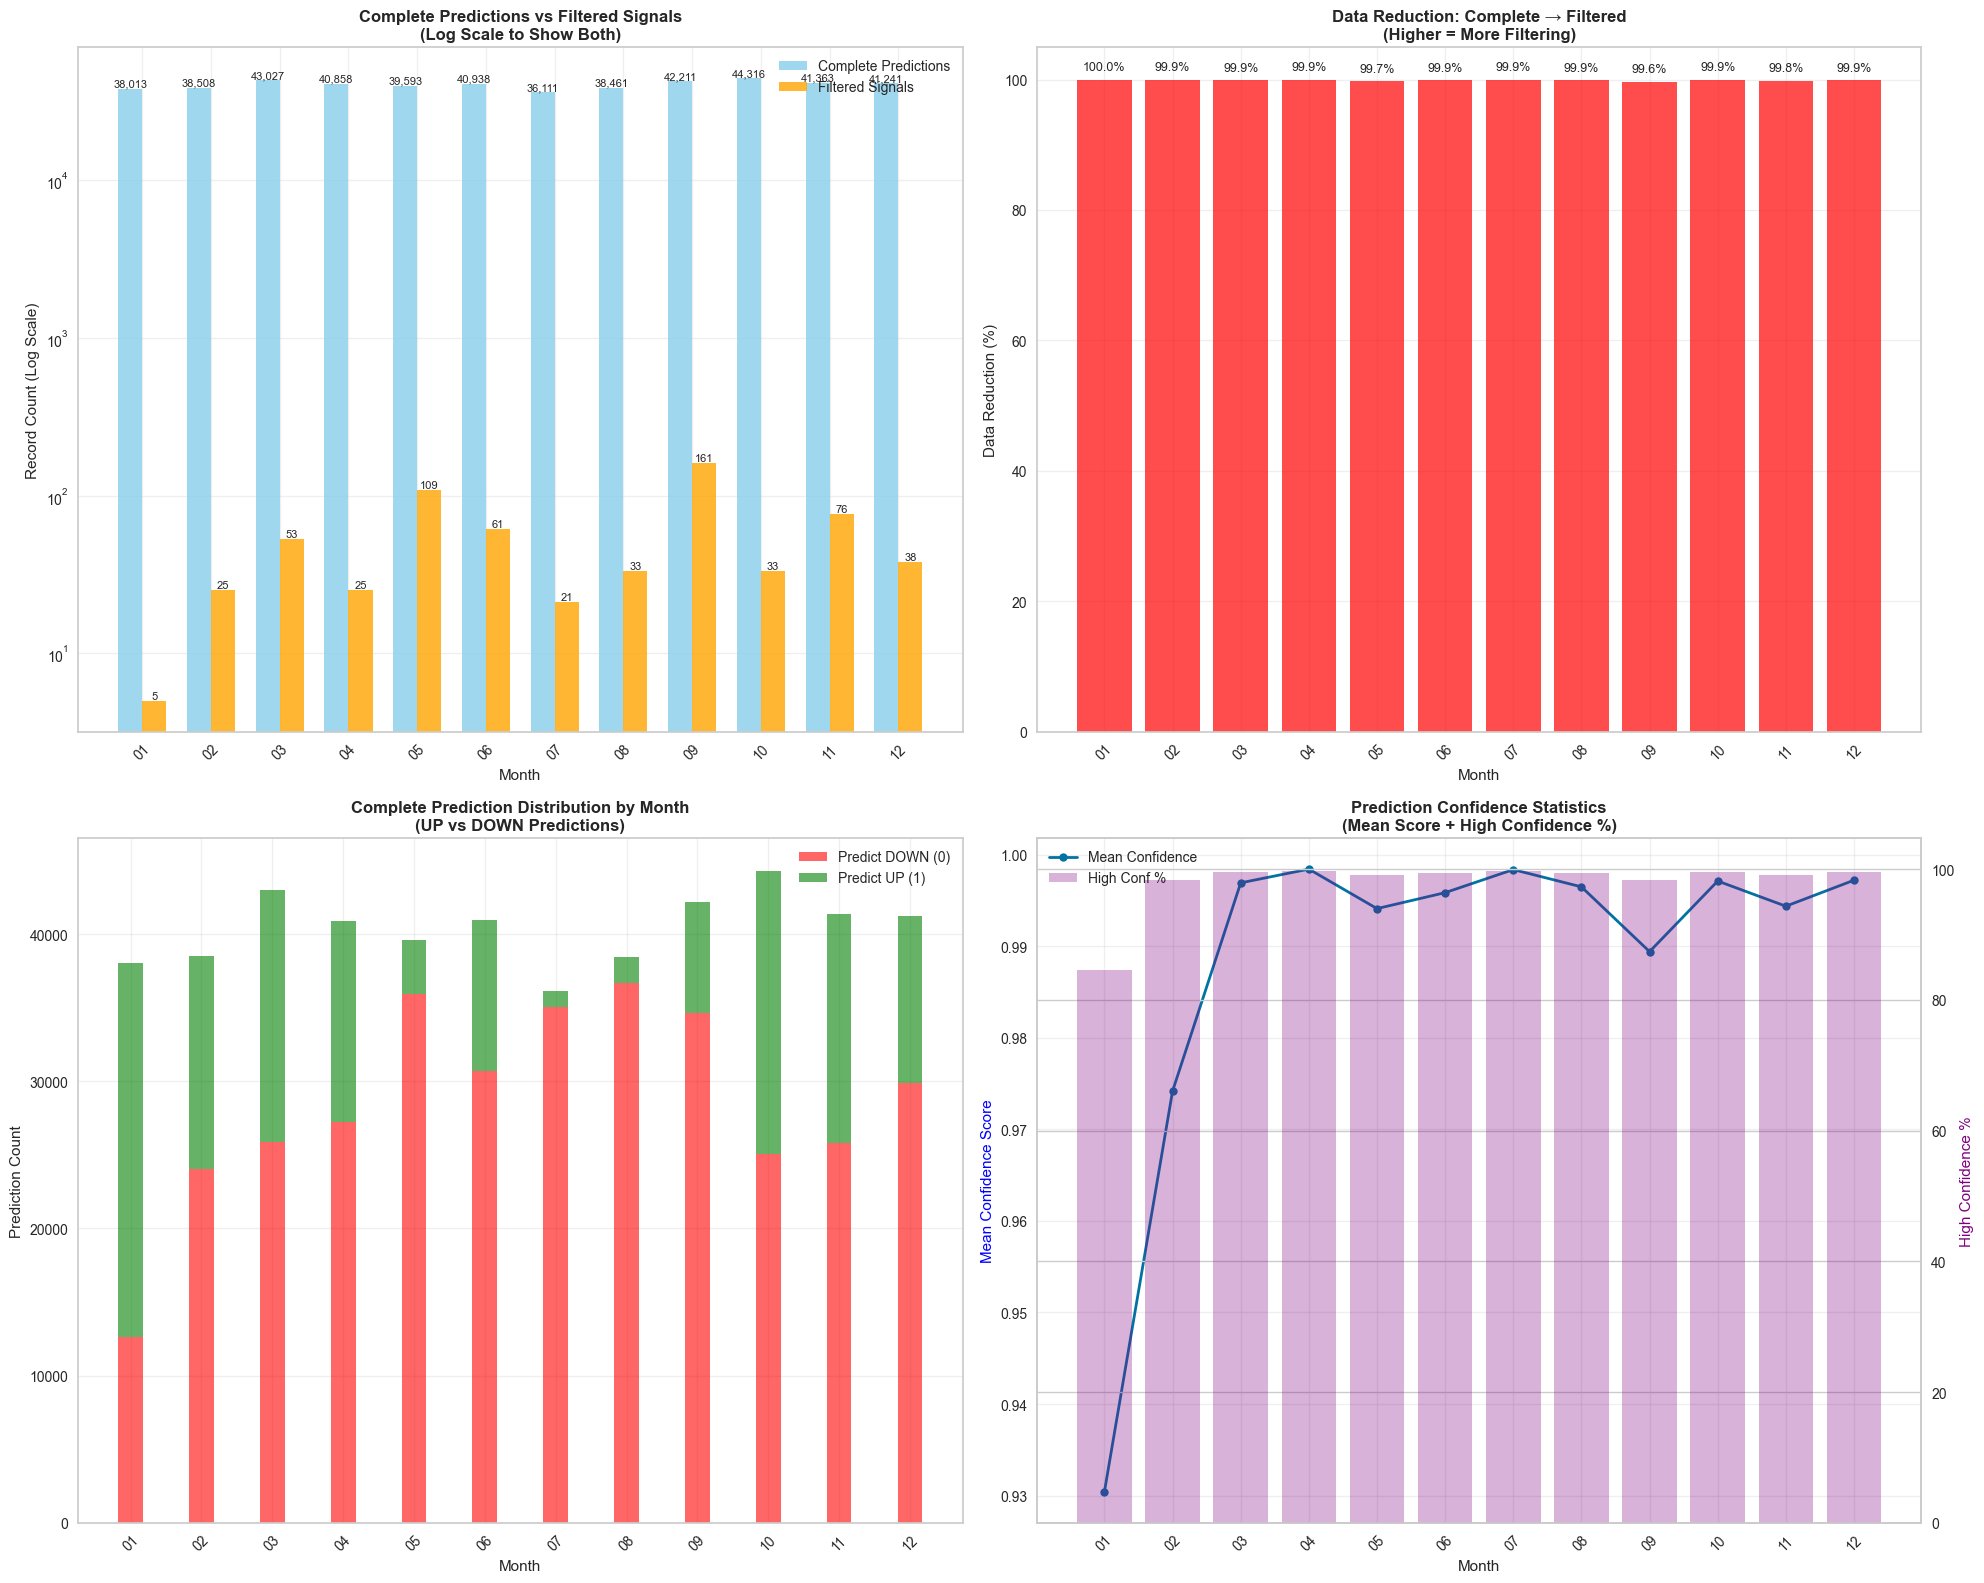


 SUMMARY COMPARISON TABLE:
   Month   Complete  Filtered  Reduction    UP%  DOWN% HighConf%
      01     38,013         5     100.0%  66.7%  33.3%     84.6%
      02     38,508        25      99.9%  37.5%  62.5%     98.4%
      03     43,027        53      99.9%  39.9%  60.1%     99.5%
      04     40,858        25      99.9%  33.3%  66.7%     99.8%
      05     39,593       109      99.7%   9.2%  90.8%     99.1%
      06     40,938        61      99.9%  25.0%  75.0%     99.4%
      07     36,111        21      99.9%   3.0%  97.0%     99.8%
      08     38,461        33      99.9%   4.7%  95.3%     99.4%
      09     42,211       161      99.6%  17.9%  82.1%     98.4%
      10     44,316        33      99.9%  43.5%  56.5%     99.6%
      11     41,363        76      99.8%  37.6%  62.4%     99.1%
      12     41,241        38      99.9%  27.5%  72.5%     99.5%
   TOTAL    484,640       640      99.9%                        

 KEY INSIGHTS:
• Total complete predictions: 484,640
• Total 

In [25]:
# Comprehensive Visualization: Complete Predictions vs Filtered Signals
print("="*80)
print("COMPLETE PREDICTIONS vs FILTERED SIGNALS VISUALIZATION")
print("="*80)

# Generate complete predictions for all months for comparison
complete_monthly_predictions = {}
print(" Generating complete predictions for all months...")

for month in ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
              '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']:
    
    try:
        print(f"  Processing {month}...")
        month_symbol = f"BTCUSD_1min_{month.replace('-', '_')}"
        month_data = load_monthly_data(month_symbol)
        
        # Generate ALL predictions (no filtering)
        month_predictions = generate_predictions(knn_model, month_data, feature_columns, model_type=model_type)
        
        # Store complete predictions
        complete_monthly_predictions[month] = {
            'total_records': len(month_predictions),
            'predictions_0': len(month_predictions[month_predictions['prediction_label'] == 0]),
            'predictions_1': len(month_predictions[month_predictions['prediction_label'] == 1]),
            'high_confidence': len(month_predictions[month_predictions['prediction_score'] >= 0.7]) if 'prediction_score' in month_predictions.columns else 0,
            'mean_confidence': month_predictions['prediction_score'].mean() if 'prediction_score' in month_predictions.columns else 0,
            'date_range': (month_predictions.index[0], month_predictions.index[-1]),
            'price_range': (month_predictions['Close'].min(), month_predictions['Close'].max())
        }
        
    except Exception as e:
        print(f"    Error processing {month}: {e}")
        complete_monthly_predictions[month] = {
            'total_records': 0, 'predictions_0': 0, 'predictions_1': 0,
            'high_confidence': 0, 'mean_confidence': 0,
            'date_range': (None, None), 'price_range': (None, None)
        }

print(f" Complete predictions generated for {len(complete_monthly_predictions)} months")

# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

months = sorted(complete_monthly_predictions.keys())
complete_counts = [complete_monthly_predictions[m]['total_records'] for m in months]
filtered_counts = [len(all_monthly_signals.get(m, [])) for m in months]

# 1. Record Count Comparison (Log Scale)
ax1 = axes[0, 0]
x_pos = range(len(months))
width = 0.35

bars1 = ax1.bar([x - width/2 for x in x_pos], complete_counts, width, 
                label='Complete Predictions', color='skyblue', alpha=0.8)
bars2 = ax1.bar([x + width/2 for x in x_pos], filtered_counts, width,
                label='Filtered Signals', color='orange', alpha=0.8)

ax1.set_yscale('log')
ax1.set_xlabel('Month')
ax1.set_ylabel('Record Count (Log Scale)')
ax1.set_title('Complete Predictions vs Filtered Signals\n(Log Scale to Show Both)', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([m.replace('2023-', '') for m in months], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (complete, filtered) in enumerate(zip(complete_counts, filtered_counts)):
    if complete > 0:
        ax1.text(i - width/2, complete, f'{complete:,}', ha='center', va='bottom', fontsize=8)
    if filtered > 0:
        ax1.text(i + width/2, filtered, f'{filtered}', ha='center', va='bottom', fontsize=8)

# 2. Data Reduction Percentage
ax2 = axes[0, 1]
reduction_pct = [(1 - filtered/complete)*100 if complete > 0 else 0 
                 for complete, filtered in zip(complete_counts, filtered_counts)]

bars = ax2.bar(months, reduction_pct, color='red', alpha=0.7)
ax2.set_xlabel('Month')
ax2.set_ylabel('Data Reduction (%)')
ax2.set_title('Data Reduction: Complete → Filtered\n(Higher = More Filtering)', fontweight='bold')
ax2.set_xticklabels([m.replace('2023-', '') for m in months], rotation=45)
ax2.grid(True, alpha=0.3)

# Add percentage labels
for i, pct in enumerate(reduction_pct):
    ax2.text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Prediction Distribution (Complete)
ax3 = axes[1, 0]
pred_0_counts = [complete_monthly_predictions[m]['predictions_0'] for m in months]
pred_1_counts = [complete_monthly_predictions[m]['predictions_1'] for m in months]

ax3.bar(x_pos, pred_0_counts, width, label='Predict DOWN (0)', color='red', alpha=0.6)
ax3.bar(x_pos, pred_1_counts, width, bottom=pred_0_counts, 
        label='Predict UP (1)', color='green', alpha=0.6)

ax3.set_xlabel('Month')
ax3.set_ylabel('Prediction Count')
ax3.set_title('Complete Prediction Distribution by Month\n(UP vs DOWN Predictions)', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([m.replace('2023-', '') for m in months], rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confidence Statistics
ax4 = axes[1, 1]
confidence_means = [complete_monthly_predictions[m]['mean_confidence'] for m in months]
high_conf_counts = [complete_monthly_predictions[m]['high_confidence'] for m in months]
high_conf_pct = [hc/tc*100 if tc > 0 else 0 for hc, tc in zip(high_conf_counts, complete_counts)]

# Plot confidence means as line
ax4_twin = ax4.twinx()
line1 = ax4.plot(months, confidence_means, 'bo-', label='Mean Confidence', linewidth=2, markersize=6)
bars = ax4_twin.bar(months, high_conf_pct, alpha=0.3, color='purple', label='High Conf %')

ax4.set_xlabel('Month')
ax4.set_ylabel('Mean Confidence Score', color='blue')
ax4_twin.set_ylabel('High Confidence %', color='purple')
ax4.set_title('Prediction Confidence Statistics\n(Mean Score + High Confidence %)', fontweight='bold')
ax4.set_xticklabels([m.replace('2023-', '') for m in months], rotation=45)
ax4.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Summary Statistics Table
print(f"\n SUMMARY COMPARISON TABLE:")
print("="*100)
print(f"{'Month':>8} {'Complete':>10} {'Filtered':>9} {'Reduction':>10} {'UP%':>6} {'DOWN%':>6} {'HighConf%':>9}")
print("="*100)

total_complete = 0
total_filtered = 0

for month in months:
    complete = complete_monthly_predictions[month]['total_records']
    filtered = len(all_monthly_signals.get(month, []))
    reduction = (1 - filtered/complete)*100 if complete > 0 else 0
    
    up_pct = complete_monthly_predictions[month]['predictions_1'] / complete * 100 if complete > 0 else 0
    down_pct = complete_monthly_predictions[month]['predictions_0'] / complete * 100 if complete > 0 else 0
    high_conf_pct = complete_monthly_predictions[month]['high_confidence'] / complete * 100 if complete > 0 else 0
    
    print(f"{month.replace('2023-', ''):>8} {complete:>10,} {filtered:>9} {reduction:>9.1f}% {up_pct:>5.1f}% {down_pct:>5.1f}% {high_conf_pct:>8.1f}%")
    
    total_complete += complete
    total_filtered += filtered

print("="*100)
total_reduction = (1 - total_filtered/total_complete)*100 if total_complete > 0 else 0
print(f"{'TOTAL':>8} {total_complete:>10,} {total_filtered:>9} {total_reduction:>9.1f}% {'':>6} {'':>6} {'':>9}")

print(f"\n KEY INSIGHTS:")
print(f"• Total complete predictions: {total_complete:,}")
print(f"• Total filtered signals: {total_filtered:,}")
print(f"• Overall data reduction: {total_reduction:.1f}%")
print(f"• Average predictions per month: {total_complete/12:,.0f}")
print(f"• Average filtered signals per month: {total_filtered/12:.0f}")

print("="*80)

In [16]:
# Fixed KNN Decision Analysis for State Change Signals
print("="*80)
print("KNN DECISION ANALYSIS FOR STATE CHANGE SIGNALS")
print("="*80)

def analyze_knn_decision_fixed(model, X_data, timestamp, features, training_data=None):
    """
    Analyze KNN decision for a specific prediction (FIXED VERSION)
    Returns the k nearest neighbors and their influence on the decision
    """
    try:
        # Get the prediction point
        if timestamp not in X_data.index:
            print(f"  Timestamp {timestamp} not found in data")
            return None
        
        prediction_row = X_data.loc[timestamp:timestamp]
        prediction_features = prediction_row[features]
        
        # Make a prediction to get the decision info
        prediction_result = generate_predictions(model, prediction_row, features, model_type=model_type)
        predicted_label = prediction_result['prediction_label'].iloc[0]
        confidence = prediction_result.get('prediction_score', [0.5]).iloc[0]
        
        # For neighbor analysis, we need to create a local KNN to find similar patterns
        # in the current month's data since we can't access the original training neighbors
        from sklearn.neighbors import NearestNeighbors
        
        # Use current month's data to find local patterns
        month_features = X_data[features].dropna()
        if len(month_features) < 10:
            print(f"  Not enough data points in month for analysis")
            return None
        
        # Create local KNN for pattern analysis
        local_knn = NearestNeighbors(n_neighbors=min(6, len(month_features)), metric='euclidean')
        local_knn.fit(month_features.values)
        
        # Find local neighbors in this month
        point_to_analyze = prediction_features.values.reshape(1, -1)
        distances, neighbor_indices = local_knn.kneighbors(point_to_analyze)
        
        analysis = {
            'timestamp': timestamp,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'neighbors': [],
            'distances': distances[0],
            'neighbor_indices': neighbor_indices[0]
        }
        
        # Get neighbor details from current month data
        for i, neighbor_idx in enumerate(neighbor_indices[0]):
            if neighbor_idx >= len(month_features):
                continue
                
            neighbor_timestamp = month_features.index[neighbor_idx]
            neighbor_row = X_data.loc[neighbor_timestamp]
            
            neighbor_info = {
                'rank': i + 1,
                'timestamp': neighbor_timestamp,
                'distance': distances[0][i],
                'price': neighbor_row['Close'],
                'actual_outcome': neighbor_row.get('future_trend', 'Unknown'),
                'features': {
                    'rsi_14d': neighbor_row.get('rsi_14d', 0),
                    'macd_12_26': neighbor_row.get('macd_12_26', 0),
                    'ema_20d': neighbor_row.get('ema_20d', 0),
                    'bb_upper_20d': neighbor_row.get('bb_upper_20d', 0),
                    'Close': neighbor_row['Close']
                }
            }
            analysis['neighbors'].append(neighbor_info)
        
        return analysis
        
    except Exception as e:
        print(f" Error in neighbor analysis: {e}")
        return None

def format_decision_analysis_fixed(analysis, signal_type):
    """Format and display the decision analysis (FIXED VERSION)"""
    if not analysis:
        return
    
    print(f"\n DECISION ANALYSIS FOR {signal_type} SIGNAL")
    print(f"Timestamp: {analysis['timestamp']}")
    print(f"Model Prediction: {analysis['predicted_label']} ({'UP' if analysis['predicted_label'] == 1 else 'DOWN'})")
    print(f"Confidence Score: {analysis['confidence']:.3f}")
    print("-" * 100)
    
    # Show neighbors table
    print(f"{'Rank':>4} {'Local Neighbor Time':>25} {'Distance':>10} {'Price':>10} {'Outcome':>8} {'RSI':>6} {'MACD':>8}")
    print("-" * 100)
    
    neighbor_outcomes = []
    for neighbor in analysis['neighbors']:
        outcome = neighbor['actual_outcome']
        if outcome != 'Unknown':
            neighbor_outcomes.append(int(outcome))
        
        rsi = neighbor['features']['rsi_14d']
        macd = neighbor['features']['macd_12_26']
        
        outcome_str = f"{int(outcome)}" if outcome != 'Unknown' else "N/A"
        
        print(f"{neighbor['rank']:>4} {neighbor['timestamp'].strftime('%Y-%m-%d %H:%M'):>25} "
              f"{neighbor['distance']:>10.3f} ${neighbor['price']:>8,.2f} "
              f"{outcome_str:>8} {rsi:>6.1f} {macd:>8.3f}")
    
    # Local consensus analysis
    if neighbor_outcomes:
        up_votes = sum(1 for outcome in neighbor_outcomes if outcome == 1)
        down_votes = sum(1 for outcome in neighbor_outcomes if outcome == 0)
        total_votes = len(neighbor_outcomes)
        
        if total_votes > 0:
            confidence = max(up_votes, down_votes) / total_votes
            
            print(f"\n LOCAL NEIGHBOR CONSENSUS (within this month):")
            print(f"  UP votes: {up_votes}/{total_votes}")
            print(f"  DOWN votes: {down_votes}/{total_votes}")
            print(f"  Local consensus: {confidence:.1%}")
            
            expected_direction = "UP" if up_votes > down_votes else "DOWN"
            actual_prediction = "UP" if analysis['predicted_label'] == 1 else "DOWN"
            
            print(f"  Local expectation: {expected_direction}")
            print(f"  Model prediction: {actual_prediction}")
            
            if expected_direction == actual_prediction:
                print(f"   Model aligns with local patterns")
            else:
                print(f"    Model disagrees with local patterns")
    
    # Feature importance for this decision
    print(f"\n SIGNAL CONDITIONS:")
    if analysis['neighbors']:
        current_features = analysis['neighbors'][0]['features']  # Use the signal point
        print(f"  Price: ${current_features['Close']:,.2f}")
        print(f"  RSI: {current_features['rsi_14d']:.2f}")
        print(f"  MACD: {current_features['macd_12_26']:.4f}")
        print(f"  EMA20: ${current_features['ema_20d']:.2f}")
        
        # Technical analysis interpretation
        rsi = current_features['rsi_14d']
        if rsi > 70:
            print(f"   RSI indicates overbought conditions")
        elif rsi < 30:
            print(f"   RSI indicates oversold conditions")
        else:
            print(f"   RSI in neutral zone")

# Analyze state change signals with FIXED logic
print(" Analyzing decision logic for state change signals...")

if 'all_monthly_signals' in locals() and all_monthly_signals:
    
    total_analyses = 0
    successful_analyses = 0
    
    # Limit analysis to prevent overwhelming output
    for month_key in sorted(all_monthly_signals.keys()):  # Analyze first 2 months
        print(f"\n{'='*60}")
        print(f"ANALYZING {month_key.upper()} STATE CHANGES")
        print(f"{'='*60}")
        
        signals_df = all_monthly_signals[month_key]
        
        if signals_df.empty:
            print(f"  No signals for {month_key}")
            continue
            
        # Load the complete month data for analysis
        try:
            month_symbol = f"BTCUSD_1min_{month_key.replace('-', '_')}"
            month_data = load_monthly_data(month_symbol)
            
            print(f" Loaded {len(month_data):,} records for decision analysis")
            
            # Find state changes
            state_changes = []
            prev_signal = None
            
            for i, row in signals_df.iterrows():
                current_signal = row['signal']
                if prev_signal is not None and prev_signal != current_signal:
                    state_changes.append({
                        'timestamp': row['timestamp'],
                        'transition': f"{prev_signal} → {current_signal}",
                        'price': row['price'],
                        'confidence': row['confidence']
                    })
                prev_signal = current_signal
            
            print(f" Found {len(state_changes)} state changes in {month_key}")
            
            # Analyze each state change (limit to 3 per month)
            for i, change in enumerate(state_changes[:3]):
                print(f"\n--- STATE CHANGE {i+1}: {change['transition']} ---")
                print(f"Time: {change['timestamp']}")
                print(f"Price: ${change['price']:,.2f}")
                print(f"Confidence: {change['confidence']:.3f}")
                
                # Perform FIXED KNN decision analysis
                analysis = analyze_knn_decision_fixed(
                    knn_model, month_data, change['timestamp'], feature_columns
                )
                
                total_analyses += 1
                
                if analysis:
                    format_decision_analysis_fixed(analysis, change['transition'])
                    successful_analyses += 1
                else:
                    print(" Could not analyze this decision")
                
                print("-" * 80)
        
        except Exception as e:
            print(f" Error analyzing {month_key}: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"\n Completed {successful_analyses}/{total_analyses} decision analyses successfully")
    
    if successful_analyses == 0:
        print(f"\n🔧 TROUBLESHOOTING TIPS:")
        print(f"1. Ensure monthly data contains required feature columns")
        print(f"2. Check that timestamps in signals match data index")
        print(f"3. Verify that future_trend column exists in data")
        print(f"4. Try running with a single month first")
    
else:
    print(" No monthly signals available. Please run the signal generation cells first.")

# Enhanced insights
print(f"\n ENHANCED DECISION ANALYSIS INSIGHTS:")
print("1. **Local Patterns**: Analysis uses neighbors from the SAME month for context")
print("2. **Model vs Local**: Compare model prediction with local historical patterns")
print("3. **Technical Context**: RSI, MACD conditions at signal generation time")
print("4. **Distance Analysis**: Closer neighbors indicate more similar market conditions")
print("5. **Consensus Strength**: Agreement level among local historical patterns")
print("\n This analysis shows WHY the model generated each state change signal")
print("by examining similar conditions within the same month.")

print("="*80)

KNN DECISION ANALYSIS FOR STATE CHANGE SIGNALS
 Analyzing decision logic for state change signals...

ANALYZING 2023-01 STATE CHANGES
Loading data for: BTCUSD_1min_2023_01
Loaded from ArcticDB - Data shape: (38013, 25)
Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend']
 Loaded 38,013 records for decision analysis
 Found 4 state changes in 2023-01

--- STATE CHANGE 1: SELL → BUY ---
Time: 2023-01-11 22:43:00
Price: $17,543.50
Confidence: 1.000
Generating predictions using pycaret model...
Feature data shape: (1, 20)
PyCaret prediction completed successfully
  Not enough data points in month for analysis
 Could not analyze this decision
--------------------------------------------------------------------------